# Gesture Recognition
In this group project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly.
First we import the required libraries to get started.

**Experiments By : Shashank Pawaskar**

#### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

| Gesture | Corresponding Action |
| --- | --- |
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

#### Goal of the Assignment
- **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

- **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved.

- **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

# Approach
- Create and Define the Functions
- Create Custom Data Generator Function
- Test Generator and Sample Model Test
- Experiment with Models
    - CNN 3D Model/s Experiments
    - CNN 3b Model/s with MaxPooling 3D Experiments
    - CNN 2D Model/s with Vanilla RNN
    - CNN 2D Model/s with RNN Variants like LSTM and GRU

# Import Required Libraries

In [2]:
# Import Libraries
#pip install opencv-python
#!pip install tensorflow==2.13.0 --ignore-installed
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
from PIL import Image, ImageFilter, ImageEnhance
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
os.environ['PYTHONHASHSEED']="30"
import abc
from sys import getsizeof
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# importing some other libraries which will be needed for model building.
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, SimpleRNN, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout
from keras import backend as K
from tensorflow.keras.utils import plot_model
from keras.applications import mobilenet

**We set the random seed so that the results don't vary drastically.**

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
#tf.set_random_seed(30)
tf.random.set_seed(30)

**I have used Jarvis, Google Colab and AWS SageMaker for Model Development, the below "opt_select" is to set the variable to pickup the dataset from respective environments**
###### Note : For AWS SageMaker, you will have to copy the dataset to the environment

In [4]:
# For Jarvis Platform
opt_select=1
# For Google Colab Platform
#opt_select=2
# For AWS SageMaker Platform
#opt_select=3

In [5]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
   TAB = '\t'

# Initialize
- In this block, you read the folder names for training and validation.
- We also set the `batch_size` here. Note that you set the batch size in such a way that we are able to use the GPU in full capacity.
- We keep increasing the batch size until the machine throws an error.

In [6]:
# Check GPU Allocation
# Check GPU Allocation
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-08-09 14:42:11.823458: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-09 14:42:11.823538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


In [7]:
# Check for GPU Configuration
!nvidia-smi

Wed Aug  9 14:42:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:3D:00.0 Off |                  Off |
| 33%   26C    P2    36W / 230W |    259MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
## Mounting Google Drive
if opt_select==2:
    from google.colab import drive
    drive.mount('/content/gdrive')
    # Setting root path for the notebook and data set
    root_path = '/content/gdrive/MyDrive/Gesture Recognition Assignment/'  #change dir to your project folder
    os.chdir(root_path)

# Generic Classes / Functions
- Collating all Functions created during Experimentation into a class for Code Cleanliness

**IMPORTANT - Refer to comments within the code if running on Jarvis**
- At one point of time the Credits on Jarvis, so continued with development on Google Colab and AWS Sagemaker.

In [9]:
# generic way to create custom callback
class LossHistoryB(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistoryB() object to store histories
loss_history_batch = LossHistoryB()
plot_data = {}

In [10]:
# callback to append loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history_epoch = LossHistory()
plot_data = {}

In [11]:
# Create Function to set the size for Model Kernel and maxpooling
# Function to set the pooling size
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [12]:
# seq_idx Function
def get_seq_idx(n_frames):
    seq_idx=np.round(np.linspace(0, 29, n_frames)).astype(int)
    return seq_idx

In [13]:
# Reference - https://docs.python.org/3/library/abc.html
class BuildModel(metaclass= abc.ABCMeta):
    def project_path(self):
        # Initialise Path and load data information
        # Path for Data Set Information
        self.data_path = './datasets/Project_data/'
        self.train_path = './datasets/Project_data/train'
        self.val_path = './datasets/Project_data/val'

        # Following Code to be commented if running notebook on Jarvis
        #to get the current working directory
        if opt_select==3:
            directory = os.getcwd()
            os.chdir(directory)
            self.data_path=os.path.join(directory, self.data_path)
            # Set the Path for the actual images for Train and Validation
            self.train_path=os.path.join(directory, self.train_path)
            self.val_path=os.path.join(directory, self.val_path)

            # Iterate directory
            for file_path in os.listdir(self.data_path):
                # check if current file_path is a file
                if os.path.isfile(os.path.join(self.data_path, file_path)):
                    # add filename to list
                    t_path=os.path.join(self.data_path, file_path)
                    if file_path=='val.csv':
                        self.val_doc=np.random.permutation(open(t_path).readlines())
                    elif file_path=='train.csv':
                        self.train_doc=np.random.permutation(open(t_path).readlines())
            # Code Commenting on Jarvis Ends Here

        # Following Code to be **Un-Commented** if Running on Google Colab or Jarvis Platform
        if opt_select!=3:
            self.train_doc = np.random.permutation(open(self.data_path+'train.csv').readlines())
            self.val_doc = np.random.permutation(open(self.data_path+'val.csv').readlines())




    # # Set data properties and parameters
    def init_properties(self,img_h=100,img_w=100):
        # image dimensions
        self.img_h=img_h  # Image Height
        self.img_w=img_w  # Image Weight
        # Channels - Since the images are in color, there are 3 channels (RGB)
        self.num_channels=3
        # Classes - From Assignment description we know that there are 5 classes
        self.num_class=5
        # Number of Frames - As per the assignment definition there are 30 frames for each video sequence
        self.n_frames=30

    # Since we will be experimenting with many models, it is better to have a function to tune the hyperparameters
    def init_hyparams(self,s_frames=30,batch_size=20,num_epochs=20):
        self.s_frames=s_frames
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    # Generator
    # This is one of the most important part of the code.
    # The overall structure of the generator has been given.
    # In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames.
    # We will experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.
    def generator(self, source_path, folder_list, augment = False, debug=False):
        if debug:
            print( 'Source path = ', source_path, '; batch size =', batch_size)
        img_idx = np.round(np.linspace(0, 29, self.n_frames)).astype(int) #create a list of image numbers (there 30 frames for each video) you want to use for a particular video
        batch_size=self.batch_size
        num_channels=self.num_channels
        num_class=self.num_class
        x = len(img_idx)
        y, z = self.img_h, self.img_w
        while True:
            t = np.random.permutation(folder_list)
            # calculate the number of batches
            if (len(t)%batch_size) == 0:
                num_batches = int(len(t)/batch_size)
            else:
                num_batches = len(t)//batch_size + 1

            if (augment):batch_data_aug = np.zeros((batch_size, x,y,y,num_channels))

            for batch in range(num_batches): # we iterate over the number of batches

                batch_data = np.zeros((batch_size,x,y,z,num_channels)) # 30 is the number of images you use for each video, (120,120) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size,num_class)) # batch_labels is the one hot representation of the output

                for folder in range(batch_size): # iterate over the batch_size
                    if debug:
                        plt.figure(figsize=(20,5))

                    #handling remaining datapoints
                    folder_idx = folder + (batch*batch_size)

                    if folder_idx >= len(t):
                        break
                    folder_str = t[folder_idx]
                    imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder

                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        # plotting original images for debugging purpose only
                        if debug:
                            plt.subplot(2, x, idx+1)
                            plt.imshow(image.astype('uint8'))

                        final_img=resize(image,(y,z,num_channels))

                        #normalizing the images
                        batch_data[folder,idx,:,:,0] = (final_img[:,:,0])/255
                        batch_data[folder,idx,:,:,1] = (final_img[:,:,1])/255
                        batch_data[folder,idx,:,:,2] = (final_img[:,:,2])/255

                        if (augment):
                            shifted = cv2.warpAffine(image,np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), (image.shape[1], image.shape[0]))

                            gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                            x0, y0 = np.argwhere(gray > 0).min(axis=0)
                            x1, y1 = np.argwhere(gray > 0).max(axis=0)

                            # cropping images for targeted gestures and noise removal.
                            cropped=shifted[x0:x1,y0:y1,:]
                            final_img=resize(cropped,(y,z,num_channels))

                            if debug:
                                plt.subplot(2, x, idx+x+1)
                                plt.imshow(final_img.astype('uint8'))

                            #batch_data[folder, idx, :,:,:] = final_img
                            batch_data_aug[folder,idx,:,:,0] = (final_img[:,:,0])/255
                            batch_data_aug[folder,idx,:,:,1] = (final_img[:,:,1])/255
                            batch_data_aug[folder,idx,:,:,2] = (final_img[:,:,2])/255

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                if (augment):
                    batch_data=np.concatenate([batch_data,batch_data_aug])
                    batch_labels=np.concatenate([batch_labels,batch_labels])

                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

    # Create and Save for each Epoch with Loss and Accuracy details
    def create_model_tain(self, model, augment_data=False, monit=True):
        # Generate Data for the Model
        train_gen = self.generator(self.train_path, self.train_doc, augment = augment_data, debug = False)
        val_gen = self.generator(self.val_path, self.val_doc, augment = False, debug = False)

        # Setting the variables to store results at each epoch
        # The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
        # Get the Train and Validation images numbers
        self.num_train_sequences = len(self.train_doc)
        #print('# training sequences =', self.num_train_sequences)
        self.num_val_sequences = len(self.val_doc)
        #print('# validation sequences =', self.num_val_sequences)
        if (self.num_train_sequences%self.batch_size) == 0:
            self.steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            self.steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            self.validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            self.validation_steps = (self.num_val_sequences//self.batch_size) + 1
        #print('# Training Epoch Steps :',self.steps_per_epoch)
        #print('# Validation Epoch Steps :',self.steps_per_epoch)

        curr_dt_time = datetime.datetime.now()
        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        # Set "save_best_only", as the model stops when the allocated disck space on the Jarvis Platform is 20 GB and model execution stops due to insufficient disk space issue (created by h5 files).
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        if (monit):
            earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=5,verbose=1)



        #callbacks_list = [checkpoint, LR, earlystop, history_epoch, loss_history_batch, decay]

        if (monit):
            callbacks_list = [checkpoint, LR, earlystop, history_epoch, loss_history_batch]
        else:
            callbacks_list = [checkpoint, LR, history_epoch, loss_history_batch]

        history=model.fit(train_gen, steps_per_epoch=self.steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_gen,
                            validation_steps=self.validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

    @abc.abstractmethod
    def define_model(self):
        pass


In [14]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(history.history['categorical_accuracy'])
    ax[1].plot(history.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(history.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(history.history['val_categorical_accuracy']))

# Goal 1 : Validate Generator
#### The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

**Generator Validation**

**Test Generator For Training Image Dataset**


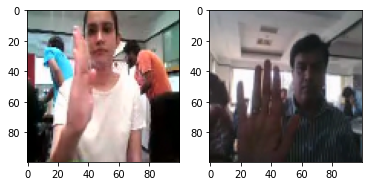

In [15]:
class Test(BuildModel):
    def define_model(self):
        pass

test_gen=Test()
test_gen.project_path()
test_gen.init_properties(img_h=100,img_w=100)
test_gen.init_hyparams(s_frames=3,batch_size=3,num_epochs=1)

print(color.BOLD+ '**Test Generator For Training Image Dataset**'+color.END)
g=test_gen.generator(test_gen.train_path,test_gen.train_doc, augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,2,:,:,:])
axes[1].imshow(batch_data[1,2,:,:,:])

**Test Generator For Validation Image Dataset**


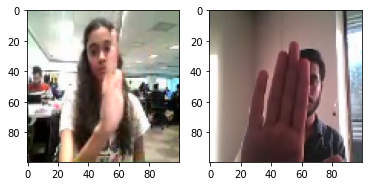

In [16]:
print(color.BOLD+'**Test Generator For Validation Image Dataset**'+color.END)
g=test_gen.generator(test_gen.val_path,test_gen.val_doc, augment=False)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,2,:,:,:])
axes[1].imshow(batch_data[1,2,:,:,:])

#### Goal 1 :  Achieved
#### Generator: The generator is able to take a batch of video Frames as input without any error. Steps like cropping, resizing and normalization  performed successfully

# Goal 2 :  Model Development
#### Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved.

#### Build Conv3D Sample Model

In [13]:
# Set Parameter for Sample Model
img_h, img_w=160,160
s_frames, batch_size, num_epochs=30, 20, 3

In [14]:
class base_CNN_3D(BuildModel):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.s_frames,self.img_h,self.img_w,self.num_channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_class,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
sample_CNN_3d=base_CNN_3D()
sample_CNN_3d.project_path()
sample_CNN_3d.init_properties(img_h=160,img_w=160)
sample_CNN_3d.init_hyparams(s_frames=30,batch_size=10,num_epochs=1)
sample_CNN_3d_model=sample_CNN_3d.define_model()
sample_CNN_3d_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

In [ ]:
sample_CNN_3d.create_model_tain(sample_CNN_3d_model)

67/67 [==============================] - ETA: 0s - loss: 1.6712 - categorical_accuracy: 0.4103  
Epoch 1: saving model to model_init_2023-08-0505_41_55.699611/model-00001-1.67123-0.41026-3.08894-0.22000.h5
67/67 [==============================] - 6052s 91s/step - loss: 1.6712 - categorical_accuracy: 0.4103 - val_loss: 3.0889 - val_categorical_accuracy: 0.2200 - lr: 0.0010


#### Sample Model Run Completed, we will now proceed with Experimentation
- Objective being to arrive the right Parameters for Frames, Batch Size and Image Dimensions

#### CNN 3D Experiments
**Objective : Indentify Impact of Frame Size, Batch Size and Image Dimension on the Model Execution**

###### Note : Tried using Keras Tuner, but getting an error -
https://github.com/keras-team/keras/issues/17368

**This seems to be a known error with Keras Tuner and yet to be fixed.**
###### Tried executing with "For" Loop, but had challenges in capturing the model results, so to save time and meet assignment timelines decided to individually call execute the models.

#### Set 1 Experiments

###### Experiment 1

In [16]:
img_h, img_w=160,160
s_frames, batch_size, num_epochs=30, 20, 3

In [17]:
Exp1_CNN_3d=base_CNN_3D()
Exp1_CNN_3d.project_path()
Exp1_CNN_3d.init_properties(img_h,img_w)
Exp1_CNN_3d.init_hyparams(s_frames, batch_size, num_epochs)
Exp1_CNN_3d_model=Exp1_CNN_3d.define_model()
Exp1_CNN_3d_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_5 (Activation)   (None, 15, 80, 80, 32)   

In [ ]:
Exp1_History=Exp1_CNN_3d.create_model_tain(Exp1_CNN_3d_model)

Epoch 1/3
34/34 [==============================] - ETA: 0s - loss: 1.5213 - categorical_accuracy: 0.4585  
Epoch 1: saving model to model_init_2023-08-0500_32_12.138663/model-00001-1.52128-0.45852-4.63615-0.16000.h5
34/34 [==============================] - 8504s 255s/step - loss: 1.5213 - categorical_accuracy: 0.4585 - val_loss: 4.6361 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/3
 1/34 [..............................] - ETA: 42:43 - loss: 0.7066 - categorical_accuracy: 0.7500

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : Exp1_CNN_3d_model'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Total Params : 3,374,789')
print(color.TAB+'# Trainable Params : 3,373,925')
print(color.TAB+'# Non Trainable Params : 864')
print(color.TAB+"# Max. Training Accuracy :", max(Exp1_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Exp1_History.history['val_categorical_accuracy']))


************Model Summary***********
# Model Name : Exp1_CNN_3d_model
	# No. of Frames :  30
	# Batch Size :  20
	# Image Dimensions : ( 160 , 160 )
	# No. of Epochs :  3
	# Total Params : 3,374,789
	# Trainable Params : 3,373,925
	# Non Trainable Params : 864
	# Max. Training Accuracy : 0.7691176533699036
	# Max. Validaiton Accuracy : 0.20000000298023224


###### Experiment 2

In [18]:
img_h, img_w=160,160
s_frames, batch_size, num_epochs=30, 30, 3

In [19]:
Exp2_CNN_3d=base_CNN_3D()
Exp2_CNN_3d.project_path()
Exp2_CNN_3d.init_properties(img_h,img_w)
Exp2_CNN_3d.init_hyparams(s_frames, batch_size, num_epochs)
Exp2_CNN_3d_model=Exp2_CNN_3d.define_model()
Exp2_CNN_3d_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_9 (Activation)   (None, 15, 80, 80, 32)   

In [ ]:
# Exp2_History=Exp2_CNN_3d.create_model_tain(Exp2_CNN_3d_model)

**Experiment 2 : Encountered Below Error**

2023-08-03 22:03:46.168061: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.37GiB (rounded to 1474560000)requested by op gradient_tape/sequential_2/max_pooling3d_8/MaxPool3D/MaxPool3DGrad

###### Experiment 3

In [20]:
img_h, img_w=160,160
s_frames, batch_size, num_epochs=45, 30, 3

In [21]:
Exp3_CNN_3d=base_CNN_3D()
Exp3_CNN_3d.project_path()
Exp3_CNN_3d.init_properties(img_h,img_w)
Exp3_CNN_3d.init_hyparams(s_frames, batch_size, num_epochs)
Exp3_CNN_3d_model=Exp3_CNN_3d.define_model()
Exp3_CNN_3d_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 45, 160, 160, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 45, 160, 160, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 45, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 23, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 23, 80, 80, 32)    4128      
                                                                 
 activation_13 (Activation)  (None, 23, 80, 80, 32)   

In [ ]:
# Exp3_History=Exp3_CNN_3d.create_model_tain(Exp3_CNN_3d_model)

**Experiment 3 : Encountered Below Error**

2023-08-03 22:06:02.905878: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB (rounded to 2211840000)requested by op sequential_4/batch_normalization_24/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer

**Experiment 2 & 3 model execution stopped due limit on memory.**

###### Experment 4

In [22]:
# Lets check the impact of Image Size on the Model
img_h, img_w=120,120
s_frames, batch_size, num_epochs=30, 30, 3

In [23]:
Exp4_CNN_3d=base_CNN_3D()
Exp4_CNN_3d.project_path()
Exp4_CNN_3d.init_properties(img_h,img_w)
Exp4_CNN_3d.init_hyparams(s_frames, batch_size, num_epochs)
Exp4_CNN_3d_model=Exp4_CNN_3d.define_model()
Exp4_CNN_3d_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_17 (Activation)  (None, 15, 60, 60, 32)   

**Note: Reducing the Image Dimensions, has more than halved the number of trainable Parameters.**

In [ ]:
Exp4_History=Exp4_CNN_3d.create_model_tain(Exp4_CNN_3d_model)

Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.5996 - categorical_accuracy: 0.4174
Epoch 00001: val_loss improved from inf to 3.37489, saving model to model_init_2023-08-0322_08_40.335271/model-00001-1.59960-0.41739-3.37489-0.13333.h5
23/23 [==============================] - 160s 7s/step - loss: 1.5996 - categorical_accuracy: 0.4174 - val_loss: 3.3749 - val_categorical_accuracy: 0.1333 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 0.9905 - categorical_accuracy: 0.5609
Epoch 00002: val_loss did not improve from 3.37489
23/23 [==============================] - 159s 7s/step - loss: 0.9905 - categorical_accuracy: 0.5609 - val_loss: 4.5962 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 0.6724 - categorical_accuracy: 0.7246
Epoch 00003: val_loss did not improve from 3.37489
23/23 [==============================] - 166s 8s/step - loss: 0.6724 - categorical_accuracy: 0.72

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : Exp4_CNN_3d_model'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Total Params : 2,195,141')
print(color.TAB+'# Trainable Params : 2,194,277')
print(color.TAB+'# Non Trainable Params : 864')
print(color.TAB+"# Max. Training Accuracy :", max(Exp4_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Exp4_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : Exp4_CNN_3d_model
	# No. of Frames :  30
	# Batch Size :  30
	# Image Dimensions : ( 120 , 120 )
	# No. of Epochs :  3
	# Total Params : 2,195,141
	# Trainable Params : 2,194,277
	# Non Trainable Params : 864
	# Max. Training Accuracy : 0.7246376872062683
	# Max. Validaiton Accuracy : 0.15833333134651184


**Model Execution  is faster when Image Dimensions arer reducted.**
- We will now check reducing the batch size.

###### Experiment 5

In [24]:
# Lets check the impact of Image Size on the Model
img_h, img_w=120,120
s_frames, batch_size, num_epochs=30, 15, 3

In [25]:
Exp5_CNN_3d=base_CNN_3D()
Exp5_CNN_3d.project_path()
Exp5_CNN_3d.init_properties(img_h,img_w)
Exp5_CNN_3d.init_hyparams(s_frames, batch_size, num_epochs)
Exp5_CNN_3d_model=Exp5_CNN_3d.define_model()
Exp5_CNN_3d_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_21 (Activation)  (None, 15, 60, 60, 32)   

In [ ]:
Exp5_History=Exp5_CNN_3d.create_model_tain(Exp5_CNN_3d_model)

Epoch 1/3
45/45 [==============================] - ETA: 0s - loss: 1.5416 - categorical_accuracy: 0.4074
Epoch 00001: val_loss improved from inf to 7.26367, saving model to model_init_2023-08-0322_26_48.946362/model-00001-1.54160-0.40741-7.26367-0.15238.h5
45/45 [==============================] - 162s 4s/step - loss: 1.5416 - categorical_accuracy: 0.4074 - val_loss: 7.2637 - val_categorical_accuracy: 0.1524 - lr: 0.0010
Epoch 2/3
45/45 [==============================] - ETA: 0s - loss: 0.9759 - categorical_accuracy: 0.6237
Epoch 00002: val_loss did not improve from 7.26367
45/45 [==============================] - 157s 4s/step - loss: 0.9759 - categorical_accuracy: 0.6237 - val_loss: 10.9426 - val_categorical_accuracy: 0.1238 - lr: 0.0010
Epoch 3/3
45/45 [==============================] - ETA: 0s - loss: 0.7809 - categorical_accuracy: 0.6844
Epoch 00003: val_loss did not improve from 7.26367
45/45 [==============================] - 160s 4s/step - loss: 0.7809 - categorical_accuracy: 0.6

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : Exp5_CNN_3d_model'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Total Params : 2,195,141')
print(color.TAB+'# Trainable Params : 2,194,277')
print(color.TAB+'# Non Trainable Params : 864')
print(color.TAB+"# Max. Training Accuracy :", max(Exp5_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Exp5_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : Exp5_CNN_3d_model
	# No. of Frames :  30
	# Batch Size :  15
	# Image Dimensions : ( 120 , 120 )
	# No. of Epochs :  3
	# Total Params : 2,195,141
	# Trainable Params : 2,194,277
	# Non Trainable Params : 864
	# Max. Training Accuracy : 0.6844444274902344
	# Max. Validaiton Accuracy : 0.190476194024086


#### Observation : We are getting High Overfit across above Experiments, lets change and define a new model and restart the experiments

**We may not be able to use this Model Architecture, as we may end up with consistently overfit the model**

# Set 2 Experimentation - New Model Architecture

###### Define Base Model for New Experimentation
**Define Parameters for the New Experiment 1 Model**

In [26]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv 3d Kernel Size, Max Pool 3d Pool Size
num_class=5
img_h, img_w=100,100
num_channels, s_frames, batch_size, num_epochs, lr_Rate, bias_init = 3, 30, 16, 3, 0, 0
neurons_density_1, neurons_density_2 = 16, 32
drop_out_1, drop_out_2 = 0.25, 0.25
kernelsize=(1,3,3)
poolsize=(1,2,2)

In [27]:
class base_CNN_3D_1(BuildModel):

    num_class=5
    seq_idx = get_seq_idx(s_frames)
    s_frames=len(seq_idx)
    def define_model(self,num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2,drop_out_1,drop_out_2,lr_Rate, bias_init):

        model = Sequential()
        model.add(Conv3D(32, make3dFilter(5), padding='same',
                 input_shape=(s_frames,img_h,self.img_w,num_channels)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(make3dFilter(3),padding='same'))

        model.add(Conv3D(64, kernelsize, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=poolsize, padding='same'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out_1))

        model.add(Conv3D(64, kernelsize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=poolsize, padding='same'))

        model.add(Flatten())
        model.add(Dense(neurons_density_1,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out_2))

        model.add(Dense(neurons_density_2,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out_2))


        model.add(Dense(self.num_class,activation='softmax'))

        if lr_Rate != 0:
          optimiser = optimizers.Adam(lr=lr_Rate)
        else:
          optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

###### New Experiment 1

In [28]:
Exp1_CNN_3d=base_CNN_3D_1()
Exp1_CNN_3d.project_path()
Exp1_CNN_3d.init_properties(img_h,img_w)
Exp1_CNN_3d.init_hyparams(s_frames, batch_size, num_epochs)
Exp1_CNN_3d_model=Exp1_CNN_3d.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2,drop_out_1,drop_out_2, lr_Rate, bias_init)
Exp1_CNN_3d_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 30, 100, 100, 32)  12032     
                                                                 
 activation_24 (Activation)  (None, 30, 100, 100, 32)  0         
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 10, 34, 34, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 10, 34, 34, 64)    18496     
                                                                 
 activation_25 (Activation)  (None, 10, 34, 34, 64)    0         
                                                                 
 max_pooling3d_25 (MaxPoolin  (None, 10, 17, 17, 64)   0         
 g3D)                                                 

In [ ]:
# New Experiment 1 without Augment Data
Exp1_History=Exp1_CNN_3d.create_model_tain(Exp1_CNN_3d_model)

Epoch 1/3


2023-08-06 19:03:25.364783: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2023-08-06 19:03:27.337120: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


42/42 [==============================] - ETA: 0s - loss: 1.9163 - categorical_accuracy: 0.2738
Epoch 00001: saving model to model_init_2023-08-0619_03_19.666992/model-00001-1.91635-0.27381-1.47862-0.18750.h5
42/42 [==============================] - 155s 4s/step - loss: 1.9163 - categorical_accuracy: 0.2738 - val_loss: 1.4786 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/3
42/42 [==============================] - ETA: 0s - loss: 1.3733 - categorical_accuracy: 0.4479
Epoch 00002: saving model to model_init_2023-08-0619_03_19.666992/model-00002-1.37331-0.44792-1.33586-0.30357.h5
42/42 [==============================] - 155s 4s/step - loss: 1.3733 - categorical_accuracy: 0.4479 - val_loss: 1.3359 - val_categorical_accuracy: 0.3036 - lr: 0.0010
Epoch 3/3
42/42 [==============================] - ETA: 0s - loss: 1.2874 - categorical_accuracy: 0.4911
Epoch 00003: saving model to model_init_2023-08-0619_03_19.666992/model-00003-1.28742-0.49107-1.55927-0.17857.h5
42/42 [===============

In [ ]:
# Capture the Model Details
print('****************New Experiment 1 Summary****************')
print(color.TAB+"# Max. Training Accuracy :", max(Exp1_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Exp1_History.history['val_categorical_accuracy']))

****************New Experiment 1 Summary****************
	# Max. Training Accuracy : 0.4910714328289032
	# Max. Validaiton Accuracy : 0.3035714328289032


###### New Experiment 2
**Same Parameters with Augment Data

In [ ]:
# New Experiment 2 without Augment Data
Exp2_History=Exp1_CNN_3d.create_model_tain(Exp1_CNN_3d_model, augment_data=True)

Epoch 1/3
42/42 [==============================] - ETA: 0s - loss: 1.2397 - categorical_accuracy: 0.4859
Epoch 00001: saving model to model_init_2023-08-0619_11_22.329026/model-00001-1.23965-0.48586-6.89465-0.14286.h5
42/42 [==============================] - 272s 7s/step - loss: 1.2397 - categorical_accuracy: 0.4859 - val_loss: 6.8946 - val_categorical_accuracy: 0.1429 - lr: 0.0010
Epoch 2/3
42/42 [==============================] - ETA: 0s - loss: 1.2216 - categorical_accuracy: 0.4926
Epoch 00002: saving model to model_init_2023-08-0619_11_22.329026/model-00002-1.22157-0.49256-1.80739-0.25893.h5
42/42 [==============================] - 272s 7s/step - loss: 1.2216 - categorical_accuracy: 0.4926 - val_loss: 1.8074 - val_categorical_accuracy: 0.2589 - lr: 0.0010
Epoch 3/3
42/42 [==============================] - ETA: 0s - loss: 1.0272 - categorical_accuracy: 0.5915
Epoch 00003: saving model to model_init_2023-08-0619_11_22.329026/model-00003-1.02723-0.59152-1.22689-0.42857.h5
42/42 [=====

In [ ]:
# Capture the Model Details
print('****************New Experiment 2 Summary****************')
print(color.TAB+"# Max. Training Accuracy :", max(Exp2_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Exp2_History.history['val_categorical_accuracy']))

****************New Experiment 2 Summary****************
	# Max. Training Accuracy : 0.5915178656578064
	# Max. Validaiton Accuracy : 0.4285714328289032


###### New Experiment 3
**Lets Change Image Dimensions and run the model**

In [29]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv 3d Kernel Size, Max Pool 3d Pool Size
num_class=5
img_h, img_w=120,120
num_channels, s_frames, batch_size, num_epochs, lr_Rate, bias_init = 3, 30, 16, 3, 0, 0
neurons_density_1, neurons_density_2 = 16, 32
drop_out_1, drop_out_2 = 0.25, 0.25
kernelsize=(1,3,3)
poolsize=(1,2,2)

In [30]:
Exp3_CNN_3d=base_CNN_3D_1()
Exp3_CNN_3d.project_path()
Exp3_CNN_3d.init_properties(img_h,img_w)
Exp3_CNN_3d.init_hyparams(s_frames, batch_size, num_epochs)
Exp3_CNN_3d_model=Exp3_CNN_3d.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2,drop_out_1,drop_out_2, lr_Rate, bias_init)
Exp3_CNN_3d_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_27 (Conv3D)          (None, 30, 120, 120, 32)  12032     
                                                                 
 activation_27 (Activation)  (None, 30, 120, 120, 32)  0         
                                                                 
 max_pooling3d_27 (MaxPoolin  (None, 10, 40, 40, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_28 (Conv3D)          (None, 10, 40, 40, 64)    18496     
                                                                 
 activation_28 (Activation)  (None, 10, 40, 40, 64)    0         
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 10, 20, 20, 64)   0         
 g3D)                                                 

In [ ]:
# Without Augment Data
Exp3_History=Exp3_CNN_3d.create_model_tain(Exp3_CNN_3d_model)

Epoch 1/3
42/42 [==============================] - ETA: 0s - loss: 1.7825 - categorical_accuracy: 0.2946
Epoch 00001: saving model to model_init_2023-08-0619_26_09.617135/model-00001-1.78247-0.29464-1.58391-0.24107.h5
42/42 [==============================] - 157s 4s/step - loss: 1.7825 - categorical_accuracy: 0.2946 - val_loss: 1.5839 - val_categorical_accuracy: 0.2411 - lr: 0.0010
Epoch 2/3
42/42 [==============================] - ETA: 0s - loss: 1.4910 - categorical_accuracy: 0.3705
Epoch 00002: saving model to model_init_2023-08-0619_26_09.617135/model-00002-1.49100-0.37054-2.55325-0.16964.h5
42/42 [==============================] - 155s 4s/step - loss: 1.4910 - categorical_accuracy: 0.3705 - val_loss: 2.5532 - val_categorical_accuracy: 0.1696 - lr: 0.0010
Epoch 3/3
42/42 [==============================] - ETA: 0s - loss: 1.3683 - categorical_accuracy: 0.4211
Epoch 00003: saving model to model_init_2023-08-0619_26_09.617135/model-00003-1.36828-0.42113-3.98623-0.16964.h5
42/42 [=====

In [ ]:
# Capture the Model Details
print('****************New Experiment 3 Summary****************')
print(color.TAB+"# Max. Training Accuracy :", max(Exp3_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Exp3_History.history['val_categorical_accuracy']))

****************New Experiment 3 Summary****************
	# Max. Training Accuracy : 0.4211309552192688
	# Max. Validaiton Accuracy : 0.2410714328289032


###### New Experiment 4
**Same Parameters from New Experiment 3, but with Augment Data**

In [ ]:
# Without Augment Data
Exp4_History=Exp3_CNN_3d.create_model_tain(Exp3_CNN_3d_model, augment_data=True)

Epoch 1/3
42/42 [==============================] - ETA: 0s - loss: 1.2232 - categorical_accuracy: 0.4881
Epoch 00001: saving model to model_init_2023-08-0619_34_49.728582/model-00001-1.22322-0.48810-11.97404-0.16071.h5
42/42 [==============================] - 279s 7s/step - loss: 1.2232 - categorical_accuracy: 0.4881 - val_loss: 11.9740 - val_categorical_accuracy: 0.1607 - lr: 0.0010
Epoch 2/3
42/42 [==============================] - ETA: 0s - loss: 1.1033 - categorical_accuracy: 0.5290
Epoch 00002: saving model to model_init_2023-08-0619_34_49.728582/model-00002-1.10326-0.52902-6.24042-0.17857.h5
42/42 [==============================] - 277s 7s/step - loss: 1.1033 - categorical_accuracy: 0.5290 - val_loss: 6.2404 - val_categorical_accuracy: 0.1786 - lr: 0.0010
Epoch 3/3
42/42 [==============================] - ETA: 0s - loss: 0.9328 - categorical_accuracy: 0.6250
Epoch 00003: saving model to model_init_2023-08-0619_34_49.728582/model-00003-0.93279-0.62500-8.64856-0.22321.h5
42/42 [===

In [ ]:
# Capture the Model Details
print('****************New Experiment 4 Summary****************')
print(color.TAB+"# Max. Training Accuracy :", max(Exp4_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Exp4_History.history['val_categorical_accuracy']))

****************New Experiment 4 Summary****************
	# Max. Training Accuracy : 0.625
	# Max. Validaiton Accuracy : 0.2232142835855484


###### New Experiment 5
**Lets now change the Batch Size, Dense (Hidden Layer) Neurons**

In [31]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv 3d Kernel Size, Max Pool 3d Pool Size
num_class=5
img_h, img_w=120,120
num_channels, s_frames, batch_size, num_epochs, lr_Rate, bias_init = 3, 30, 30, 3, 0, 0
neurons_density_1, neurons_density_2 = 32, 64
drop_out_1, drop_out_2 = 0.25, 0.25
kernelsize=(1,3,3)
poolsize=(1,2,2)

In [32]:
Exp5_CNN_3d=base_CNN_3D_1()
Exp5_CNN_3d.project_path()
Exp5_CNN_3d.init_properties(img_h,img_w)
Exp5_CNN_3d.init_hyparams(s_frames, batch_size, num_epochs)
Exp5_CNN_3d_model=Exp5_CNN_3d.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2,drop_out_1,drop_out_2, lr_Rate, bias_init)
Exp5_CNN_3d_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_30 (Conv3D)          (None, 30, 120, 120, 32)  12032     
                                                                 
 activation_30 (Activation)  (None, 30, 120, 120, 32)  0         
                                                                 
 max_pooling3d_30 (MaxPoolin  (None, 10, 40, 40, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_31 (Conv3D)          (None, 10, 40, 40, 64)    18496     
                                                                 
 activation_31 (Activation)  (None, 10, 40, 40, 64)    0         
                                                                 
 max_pooling3d_31 (MaxPoolin  (None, 10, 20, 20, 64)   0         
 g3D)                                                 

In [ ]:
# New Experiment 5 without Augment Data
Exp5_History=Exp5_CNN_3d.create_model_tain(Exp5_CNN_3d_model)

Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.6192 - categorical_accuracy: 0.3565
Epoch 00001: saving model to model_init_2023-08-0619_49_45.812407/model-00001-1.61925-0.35652-1.43725-0.23333.h5
23/23 [==============================] - 156s 7s/step - loss: 1.6192 - categorical_accuracy: 0.3565 - val_loss: 1.4373 - val_categorical_accuracy: 0.2333 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 1.3917 - categorical_accuracy: 0.4217
Epoch 00002: saving model to model_init_2023-08-0619_49_45.812407/model-00002-1.39170-0.42174-1.32336-0.28333.h5
23/23 [==============================] - 158s 7s/step - loss: 1.3917 - categorical_accuracy: 0.4217 - val_loss: 1.3234 - val_categorical_accuracy: 0.2833 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 1.1227 - categorical_accuracy: 0.5333
Epoch 00003: saving model to model_init_2023-08-0619_49_45.812407/model-00003-1.12268-0.53333-1.38883-0.15833.h5
23/23 [=====

In [ ]:
# Capture the Model Details
print('****************New Experiment 5 Summary****************')
print(color.TAB+"# Max. Training Accuracy :", max(Exp5_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Exp5_History.history['val_categorical_accuracy']))

****************New Experiment 5 Summary****************
	# Max. Training Accuracy : 0.5333333611488342
	# Max. Validaiton Accuracy : 0.28333333134651184


###### New Experiment 6
**Same Parameters from New Experiment 5, but with Augment Data

In [ ]:
# New Experiment 6 with Augment Data
Exp6_History=Exp5_CNN_3d.create_model_tain(Exp5_CNN_3d_model, augment_data=True)

Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 0.9762 - categorical_accuracy: 0.5833 
Epoch 00001: saving model to model_init_2023-08-0619_58_21.413036/model-00001-0.97624-0.58333-1.66799-0.15833.h5
23/23 [==============================] - 278s 12s/step - loss: 0.9762 - categorical_accuracy: 0.5833 - val_loss: 1.6680 - val_categorical_accuracy: 0.1583 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 0.8124 - categorical_accuracy: 0.6623 
Epoch 00002: saving model to model_init_2023-08-0619_58_21.413036/model-00002-0.81242-0.66232-5.40297-0.14167.h5
23/23 [==============================] - 275s 12s/step - loss: 0.8124 - categorical_accuracy: 0.6623 - val_loss: 5.4030 - val_categorical_accuracy: 0.1417 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 0.6998 - categorical_accuracy: 0.7000 
Epoch 00003: saving model to model_init_2023-08-0619_58_21.413036/model-00003-0.69983-0.70000-2.24241-0.14167.h5
23/23 [

In [ ]:
# Capture the Model Details
print('****************New Experiment 6 Summary****************')
print(color.TAB+"# Max. Training Accuracy :", max(Exp6_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Exp6_History.history['val_categorical_accuracy']))

****************New Experiment 6 Summary****************
	# Max. Training Accuracy : 0.699999988079071
	# Max. Validaiton Accuracy : 0.15833333134651184


**Had Encountered Below Error for Experiment 6 when I run it for first time. Next Time it Run without any issues (no changes to parameters were made by me**

**"2023-08-06 12:53:21.007800: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.09GiB"**

**Seems Like memory issues with GPU across runs may differ**

###### New Experiment 7
**Parameters Same as New Experiments 5 and 6, with increase Dropout Rate and Image Dimensions (100,100)

In [33]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv 3d Kernel Size, Max Pool 3d Pool Size
num_class=5
img_h, img_w=100,100
num_channels, s_frames, batch_size, num_epochs, lr_Rate, bias_init = 3, 30, 30, 3, 0, 0
neurons_density_1, neurons_density_2 = 32, 64
drop_out_1, drop_out_2 = 0.25, 0.5
kernelsize=(1,3,3)
poolsize=(1,2,2)

In [34]:
Exp7_CNN_3d=base_CNN_3D_1()
Exp7_CNN_3d.project_path()
Exp7_CNN_3d.init_properties(img_h,img_w)
Exp7_CNN_3d.init_hyparams(s_frames, batch_size, num_epochs)
Exp7_CNN_3d_model=Exp7_CNN_3d.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2,drop_out_1,drop_out_2, lr_Rate, bias_init)
Exp7_CNN_3d_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_33 (Conv3D)          (None, 30, 100, 100, 32)  12032     
                                                                 
 activation_33 (Activation)  (None, 30, 100, 100, 32)  0         
                                                                 
 max_pooling3d_33 (MaxPoolin  (None, 10, 34, 34, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_34 (Conv3D)          (None, 10, 34, 34, 64)    18496     
                                                                 
 activation_34 (Activation)  (None, 10, 34, 34, 64)    0         
                                                                 
 max_pooling3d_34 (MaxPoolin  (None, 10, 17, 17, 64)   0         
 g3D)                                                 

In [ ]:
# New Experiment 7 without Augment Data
Exp7_History=Exp7_CNN_3d.create_model_tain(Exp7_CNN_3d_model)

Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 2.3362 - categorical_accuracy: 0.2406
Epoch 00001: saving model to model_init_2023-08-0620_14_49.198223/model-00001-2.33616-0.24058-1.99353-0.18333.h5
23/23 [==============================] - 155s 7s/step - loss: 2.3362 - categorical_accuracy: 0.2406 - val_loss: 1.9935 - val_categorical_accuracy: 0.1833 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 2.0519 - categorical_accuracy: 0.2826
Epoch 00002: saving model to model_init_2023-08-0620_14_49.198223/model-00002-2.05186-0.28261-1.97936-0.15833.h5
23/23 [==============================] - 152s 7s/step - loss: 2.0519 - categorical_accuracy: 0.2826 - val_loss: 1.9794 - val_categorical_accuracy: 0.1583 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 1.8588 - categorical_accuracy: 0.3058
Epoch 00003: saving model to model_init_2023-08-0620_14_49.198223/model-00003-1.85876-0.30580-1.90836-0.16667.h5
23/23 [=====

In [ ]:
# Capture the Model Details
print('****************New Experiment 7 Summary****************')
print(color.TAB+"# Max. Training Accuracy :", max(Exp7_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Exp7_History.history['val_categorical_accuracy']))

****************New Experiment 7 Summary****************
	# Max. Training Accuracy : 0.30579710006713867
	# Max. Validaiton Accuracy : 0.18333333730697632


###### New Experiment 8
**Parameters same as Experiment 7, but with Augment Data**

In [ ]:
# without Augment Data
Exp8_History=Exp7_CNN_3d.create_model_tain(Exp7_CNN_3d_model, augment_data=True)

Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.6818 - categorical_accuracy: 0.3217 
Epoch 00001: saving model to model_init_2023-08-0620_22_56.532054/model-00001-1.68178-0.32174-3.78818-0.15833.h5
23/23 [==============================] - 269s 12s/step - loss: 1.6818 - categorical_accuracy: 0.3217 - val_loss: 3.7882 - val_categorical_accuracy: 0.1583 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 1.6695 - categorical_accuracy: 0.3464 
Epoch 00002: saving model to model_init_2023-08-0620_22_56.532054/model-00002-1.66954-0.34638-1.86474-0.25000.h5
23/23 [==============================] - 270s 12s/step - loss: 1.6695 - categorical_accuracy: 0.3464 - val_loss: 1.8647 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 1.5001 - categorical_accuracy: 0.3819 
Epoch 00003: saving model to model_init_2023-08-0620_22_56.532054/model-00003-1.50005-0.38188-1.37791-0.29167.h5
23/23 [

In [ ]:
# Capture the Model Details
print('****************New Experiment 8 Summary****************')
print(color.TAB+"# Max. Training Accuracy :", max(Exp7_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Exp7_History.history['val_categorical_accuracy']))

****************New Experiment 8 Summary****************
	# Max. Training Accuracy : 0.30579710006713867
	# Max. Validaiton Accuracy : 0.18333333730697632


**Had Encountered Below Error for Experiment 6 when I run it for first time. Next Time it Run without any issues (no changes to parameters were made by me**
**"2023-08-06 13:12:47.907681: W tensorflow/core/common_runtime/bfc_allocator.cc:344] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation."**

**Seems Like memory issues with GPU across runs may differ**

#### Set 2 Experiments have some consistency, we will this model architecure and execute model with different parameters and customizations

# Model Development

# Conv 3D

#### Set 2 Model 1 - CNN 3D
###### Models Based on Model Architecture Defined in Set 2 Experiments
**Parameters based on New Experiment 2**

In [55]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv 3d Kernel Size, Max Pool 3d Pool Size
num_class=5
img_h, img_w=100,100
num_channels, s_frames, batch_size, num_epochs, lr_Rate, bias_init = 3, 30, 16, 25,0, 0
neurons_density_1, neurons_density_2 = 16, 32
drop_out_1, drop_out_2 = 0.25, 0.25
kernelsize=(1,3,3)
poolsize=(1,2,2)

In [56]:
class Base_Model_2(BuildModel):
    num_class=5
    seq_idx = get_seq_idx(s_frames)
    s_frames=len(seq_idx)
    def define_model(self,num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2,drop_out_1,drop_out_2,lr_Rate, bias_init):

        model = Sequential()
        model.add(Conv3D(32, make3dFilter(5), padding='same',
                 input_shape=(s_frames,img_h,self.img_w,num_channels)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(make3dFilter(3),padding='same'))

        model.add(Conv3D(64, kernelsize, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=poolsize, padding='same'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out_1))

        model.add(Conv3D(64, kernelsize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=poolsize, padding='same'))

        model.add(Flatten())
        model.add(Dense(neurons_density_1,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out_2))

        model.add(Dense(neurons_density_2,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out_2))


        model.add(Dense(self.num_class,activation='softmax'))

        if lr_Rate != 0:
          optimiser = optimizers.Adam(lr=lr_Rate)
        else:
          optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

###### Set 2 Model Architecture : Model 1

In [57]:
Set2_Model_1=Base_Model_2()
Set2_Model_1.project_path()
Set2_Model_1.init_properties(img_h,img_w)
Set2_Model_1.init_hyparams(s_frames, batch_size, num_epochs)
CNN_3d_set2_model_1=Set2_Model_1.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2, drop_out_1,drop_out_2,lr_Rate, bias_init)
CNN_3d_set2_model_1.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 30, 100, 100, 32)  12032     
                                                                 
 activation_60 (Activation)  (None, 30, 100, 100, 32)  0         
                                                                 
 max_pooling3d_60 (MaxPoolin  (None, 10, 34, 34, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_61 (Conv3D)          (None, 10, 34, 34, 64)    18496     
                                                                 
 activation_61 (Activation)  (None, 10, 34, 34, 64)    0         
                                                                 
 max_pooling3d_61 (MaxPoolin  (None, 10, 17, 17, 64)   0         
 g3D)                                                

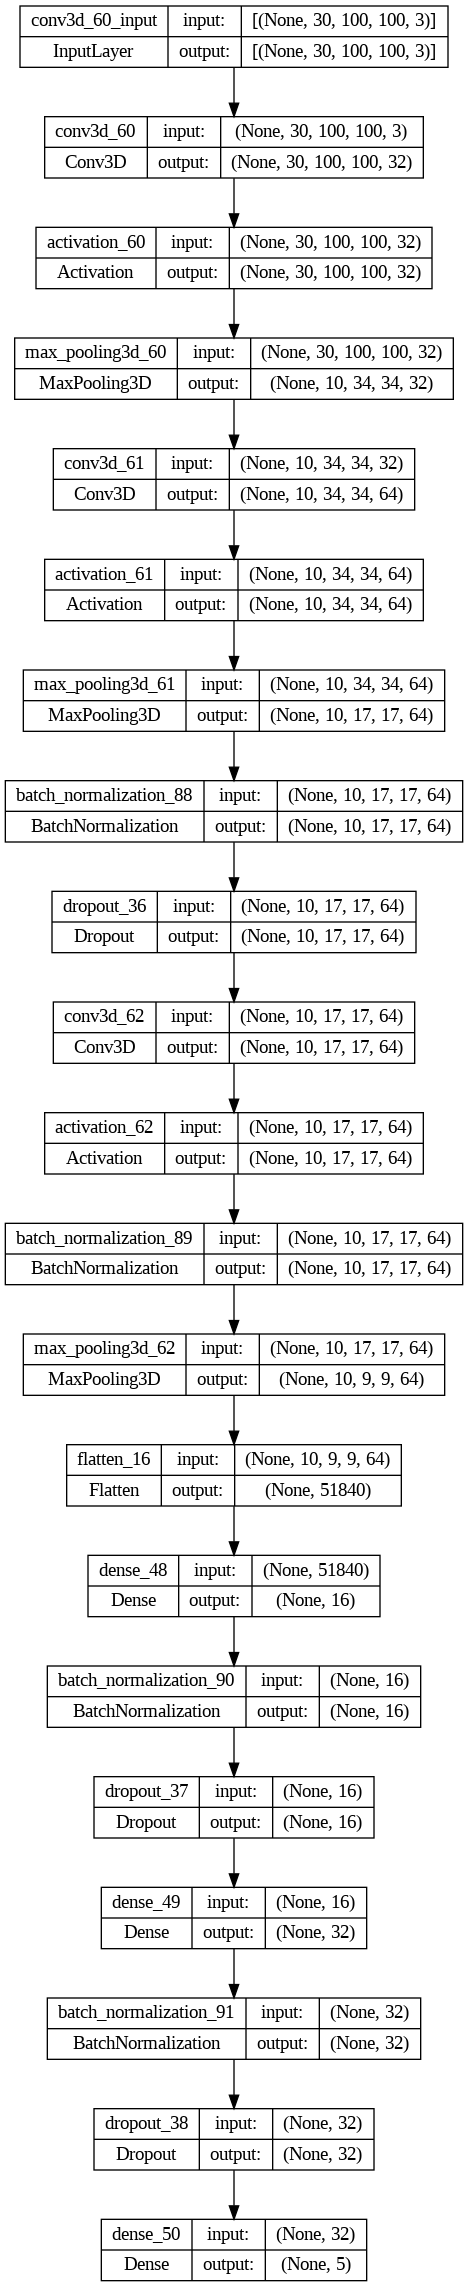

In [58]:
# Visualize the Model Architecture
plot_model(CNN_3d_set2_model_1, to_file='CNN_3d_set2_model_1.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Set 2 : Model 1 with Augment Data
Set2_Model_1_History=Set2_Model_1.create_model_tain(CNN_3d_set2_model_1,augment_data=True)

Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 1.8961 - categorical_accuracy: 0.2917
Epoch 00001: saving model to model_init_2023-08-0620_41_06.607952/model-00001-1.89611-0.29167-2.41295-0.21429.h5
42/42 [==============================] - 272s 7s/step - loss: 1.8961 - categorical_accuracy: 0.2917 - val_loss: 2.4130 - val_categorical_accuracy: 0.2143 - lr: 0.0010
Epoch 2/25
42/42 [==============================] - ETA: 0s - loss: 1.5059 - categorical_accuracy: 0.3690
Epoch 00002: saving model to model_init_2023-08-0620_41_06.607952/model-00002-1.50591-0.36905-1.79246-0.15179.h5
42/42 [==============================] - 271s 7s/step - loss: 1.5059 - categorical_accuracy: 0.3690 - val_loss: 1.7925 - val_categorical_accuracy: 0.1518 - lr: 0.0010
Epoch 3/25
42/42 [==============================] - ETA: 0s - loss: 1.3523 - categorical_accuracy: 0.4390
Epoch 00003: saving model to model_init_2023-08-0620_41_06.607952/model-00003-1.35230-0.43899-2.17948-0.16071.h5
42/42 [==

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(Set2_Model_1_History.history)
hist_csv_file = 'Set2_Model_1_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

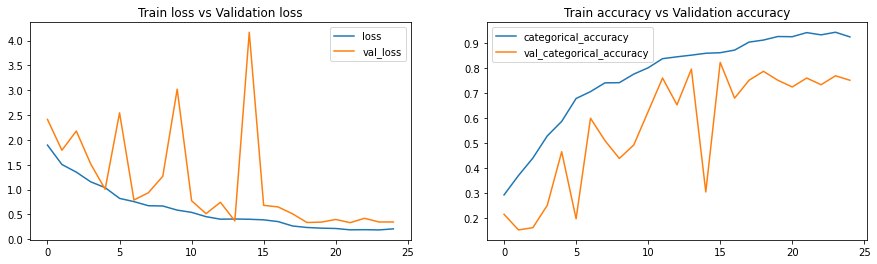

Max. Training Accuracy 0.9419642686843872
Max. Validaiton Accuracy 0.8214285969734192


In [ ]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(Set2_Model_1_History)

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : Set2_Model_1_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Conv3D Layer Kernel Size :',kernelsize)
print(color.TAB+'# MaxPool3D Pool Size : ', poolsize)
print(color.TAB+'# Total Params : 898,325')
print(color.TAB+'# Trainable Params : 897,973')
print(color.TAB+'# Non Trainable Params : 352')
print(color.TAB+"# Max. Training Accuracy :", max(Set2_Model_1_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Set2_Model_1_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : Set2_Model_1_History
	# No. of Frames :  30
	# Batch Size :  16
	# Image Dimensions : ( 100 , 100 )
	# No. of Epochs :  25
	# Conv3D Layer Kernel Size : (1, 3, 3)
	# MaxPool3D Pool Size :  (1, 2, 2)
	# Total Params : 898,325
	# Trainable Params : 897,973
	# Non Trainable Params : 352
	# Max. Training Accuracy : 0.9419642686843872
	# Max. Validaiton Accuracy : 0.8214285969734192


**Better Training and Validation Loss and Accuracy**
**Loss Training and Validation Loss and Accuracy trending nicely, but with some peaks and valleys**
**model-00022-0.19102-0.94048-0.33544-0.75893.h5** 
- with Training Loss-0.1910, Validation Loss - 0.3354, Training Accuracy - 0.9405, Validation Accuracy - 0.7589, are the best rates for the model. 
**Lets see if we can Further Improvement in both Loss and Accuracies**

###### Set 2 Model Architecture : Model 2
**Without Augment Data

In [ ]:
# Set 2 : Model 2 without Augment Data
Set2_Model_2_History=Set2_Model_1.create_model_tain(CNN_3d_set2_model_1)

Epoch 1/25


2023-08-06 22:53:55.330925: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


42/42 [==============================] - ETA: 0s - loss: 1.7844 - categorical_accuracy: 0.3259
Epoch 00001: saving model to model_init_2023-08-0622_53_49.427736/model-00001-1.78441-0.32589-1.55037-0.21429.h5
42/42 [==============================] - 167s 4s/step - loss: 1.7844 - categorical_accuracy: 0.3259 - val_loss: 1.5504 - val_categorical_accuracy: 0.2143 - lr: 0.0010
Epoch 2/25
42/42 [==============================] - ETA: 0s - loss: 1.3597 - categorical_accuracy: 0.4524
Epoch 00002: saving model to model_init_2023-08-0622_53_49.427736/model-00002-1.35973-0.45238-1.45161-0.19643.h5
42/42 [==============================] - 168s 4s/step - loss: 1.3597 - categorical_accuracy: 0.4524 - val_loss: 1.4516 - val_categorical_accuracy: 0.1964 - lr: 0.0010
Epoch 3/25
42/42 [==============================] - ETA: 0s - loss: 1.2448 - categorical_accuracy: 0.5060
Epoch 00003: saving model to model_init_2023-08-0622_53_49.427736/model-00003-1.24484-0.50595-1.49898-0.25000.h5
42/42 [=============

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(Set2_Model_2_History.history)
hist_csv_file = 'Set2_Model_2_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

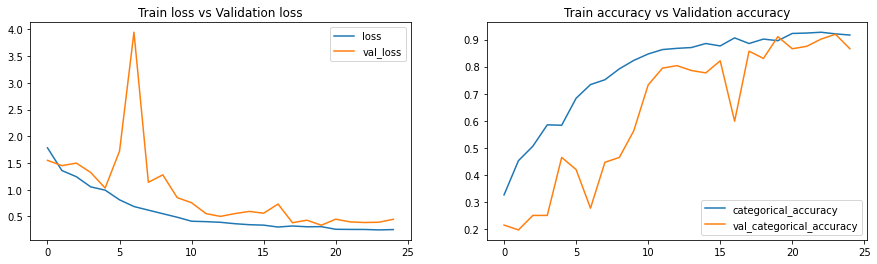

Max. Training Accuracy 0.9270833134651184
Max. Validaiton Accuracy 0.9196428656578064


In [ ]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(Set2_Model_2_History)

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : Set2_Model_2_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Conv3D Layer Kernel Size :',kernelsize)
print(color.TAB+'# MaxPool3D Pool Size : ', poolsize)
print(color.TAB+'# Total Params : 898,325')
print(color.TAB+'# Trainable Params : 897,973')
print(color.TAB+'# Non Trainable Params : 352')
print(color.TAB+"# Max. Training Accuracy :", max(Set2_Model_2_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Set2_Model_2_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : Set2_Model_2_History
	# No. of Frames :  30
	# Batch Size :  16
	# Image Dimensions : ( 100 , 100 )
	# No. of Epochs :  25
	# Conv3D Layer Kernel Size : (1, 3, 3)
	# MaxPool3D Pool Size :  (1, 2, 2)
	# Total Params : 898,325
	# Trainable Params : 897,973
	# Non Trainable Params : 352
	# Max. Training Accuracy : 0.9270833134651184
	# Max. Validaiton Accuracy : 0.9196428656578064


**Better Training and Validation Loss and Accuracy**
**Loss Training and Validation Loss and Accuracy trending nicely, but with less number of peaks and valleys**
**model-00024-0.24873-0.92113-0.39267-0.91964.h5** 
- with Training Loss- 0.2487, Validation Loss - 0.3927, Training Accuracy - 0.9271, Validation Accuracy - 0.91964, are the best rates for the model. 
**Lets see if we can Further Improvement in both Loss and Accuracies**

###### Set 2 Model Architecture : Model 3
**Parameters same as New Experiment 3**

In [59]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv 3d Kernel Size, Max Pool 3d Pool Size
num_class=5
img_h, img_w=120,120
num_channels, s_frames, batch_size, num_epochs, lr_Rate, bias_init = 3, 30, 16, 30, 0, 0
neurons_density_1, neurons_density_2 = 16, 32
drop_out_1, drop_out_2 = 0.25, 0.25
kernelsize=(1,3,3)
poolsize=(1,2,2)

In [60]:
Set2_Model_3=Base_Model_2()
Set2_Model_3.project_path()
Set2_Model_3.init_properties(img_h,img_w)
Set2_Model_3.init_hyparams(s_frames, batch_size, num_epochs)
CNN_3d_set2_model_3=Set2_Model_3.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2, drop_out_1,drop_out_2,lr_Rate, bias_init)
CNN_3d_set2_model_3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_63 (Conv3D)          (None, 30, 120, 120, 32)  12032     
                                                                 
 activation_63 (Activation)  (None, 30, 120, 120, 32)  0         
                                                                 
 max_pooling3d_63 (MaxPoolin  (None, 10, 40, 40, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_64 (Conv3D)          (None, 10, 40, 40, 64)    18496     
                                                                 
 activation_64 (Activation)  (None, 10, 40, 40, 64)    0         
                                                                 
 max_pooling3d_64 (MaxPoolin  (None, 10, 20, 20, 64)   0         
 g3D)                                                

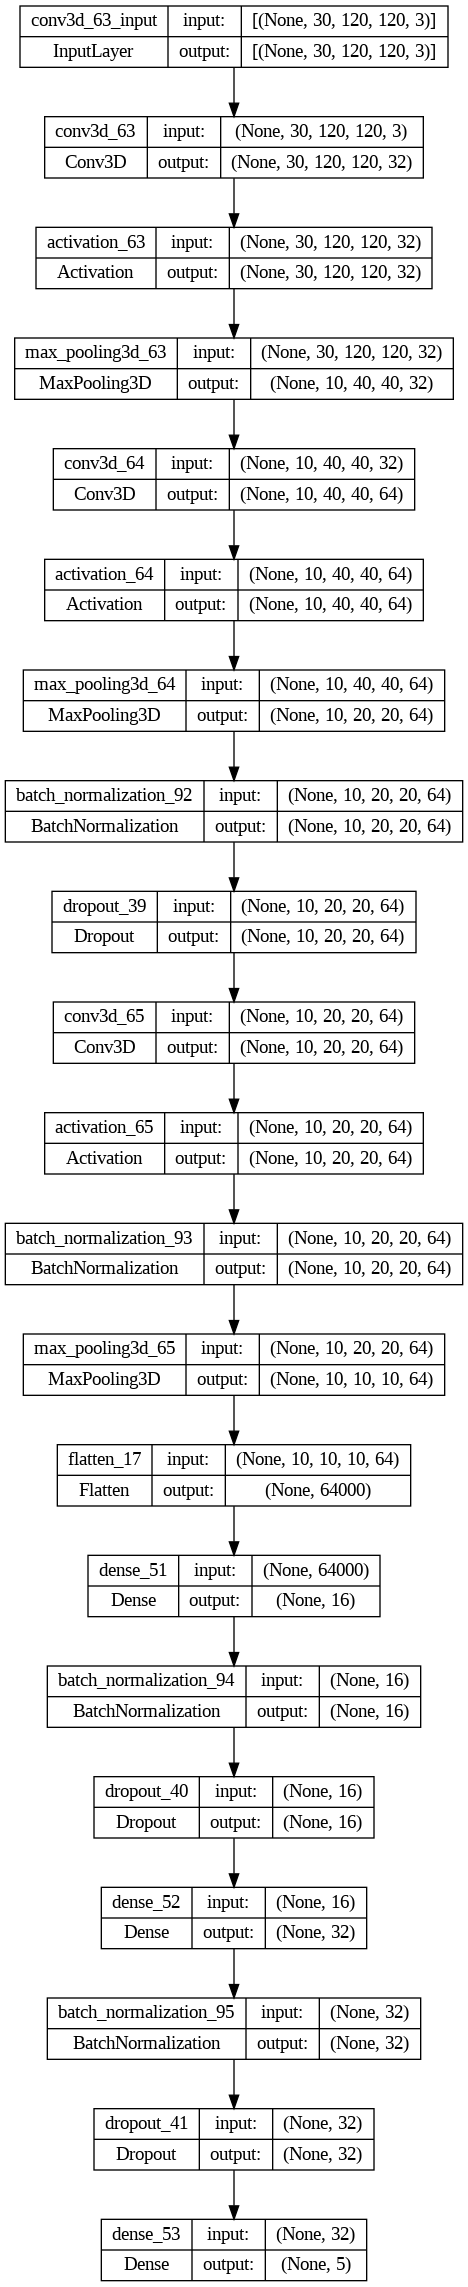

In [61]:
# Visualize the Model Architecture
plot_model(CNN_3d_set2_model_3, to_file='CNN_3d_set2_model_3.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Set 2 : Model 3 with Augment Data
Set2_Model_3_History=Set2_Model_3.create_model_tain(CNN_3d_set2_model_3,augment_data=True)

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.6854 - categorical_accuracy: 0.3363
Epoch 00001: saving model to model_init_2023-08-0700_05_09.504915/model-00001-1.68540-0.33631-1.71462-0.22321.h5
42/42 [==============================] - 323s 8s/step - loss: 1.6854 - categorical_accuracy: 0.3363 - val_loss: 1.7146 - val_categorical_accuracy: 0.2232 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.3131 - categorical_accuracy: 0.4635
Epoch 00002: saving model to model_init_2023-08-0700_05_09.504915/model-00002-1.31312-0.46354-1.60153-0.26786.h5
42/42 [==============================] - 305s 7s/step - loss: 1.3131 - categorical_accuracy: 0.4635 - val_loss: 1.6015 - val_categorical_accuracy: 0.2679 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.0998 - categorical_accuracy: 0.5647
Epoch 00003: saving model to model_init_2023-08-0700_05_09.504915/model-00003-1.09978-0.56473-4.11135-0.08929.h5
42/42 [==

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(Set2_Model_3_History.history)
hist_csv_file = 'Set2_Model_3_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

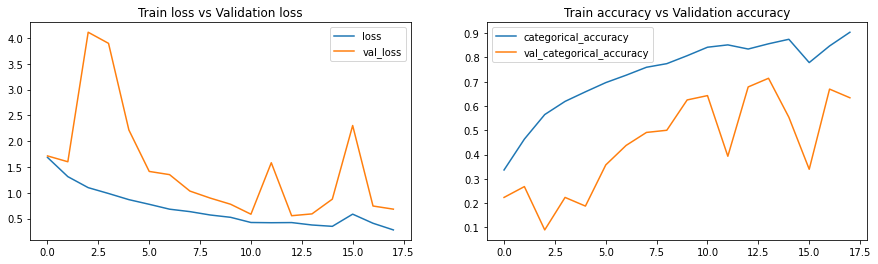

Max. Training Accuracy 0.9040178656578064
Max. Validaiton Accuracy 0.7142857313156128


In [ ]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(Set2_Model_3_History)

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : Set2_Model_3_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Conv3D Layer Kernel Size :',kernelsize)
print(color.TAB+'# MaxPool3D Pool Size : ', poolsize)
print(color.TAB+'# Total Params : 1,092,885')
print(color.TAB+'# Trainable Params : 1,092,533')
print(color.TAB+'# Non Trainable Params : 352')
print(color.TAB+"# Max. Training Accuracy :", max(Set2_Model_3_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Set2_Model_3_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : Set2_Model_3_History
	# No. of Frames :  30
	# Batch Size :  16
	# Image Dimensions : ( 120 , 120 )
	# No. of Epochs :  30
	# Conv3D Layer Kernel Size : (1, 3, 3)
	# MaxPool3D Pool Size :  (1, 2, 2)
	# Total Params : 1,092,885
	# Trainable Params : 1,092,533
	# Non Trainable Params : 352
	# Max. Training Accuracy : 0.9040178656578064
	# Max. Validaiton Accuracy : 0.7142857313156128


**Drop in Training and Validation Loss and Accuracy**
**Loss Training and Validation Loss and Accuracy trending indicate model is bit overfitting**
**model-00018-0.28052-0.90402-0.68291-0.63393.h5** 
- with Training Loss- 0.2805, Validation Loss - 0.6829, Training Accuracy - 0.9040, Validation Accuracy - 0.6339, are the best rates for the model. 
**Lets see if we can Further Improvement in both Loss and Accuracies**

###### Set 2 Experiment Model Architecture : Mode 4
**Same Parameters as Set 2 Model 3, but without Augment Data

In [ ]:
# Set 2 : Model 4 without Augment Data
Set2_Model_4_History=Set2_Model_3.create_model_tain(CNN_3d_set2_model_3)

Epoch 1/30


2023-08-07 01:44:23.239410: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


42/42 [==============================] - ETA: 0s - loss: 1.7962 - categorical_accuracy: 0.2976
Epoch 00001: saving model to model_init_2023-08-0701_44_15.789096/model-00001-1.79621-0.29762-2.68486-0.29464.h5
42/42 [==============================] - 185s 4s/step - loss: 1.7962 - categorical_accuracy: 0.2976 - val_loss: 2.6849 - val_categorical_accuracy: 0.2946 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.5256 - categorical_accuracy: 0.3943
Epoch 00002: saving model to model_init_2023-08-0701_44_15.789096/model-00002-1.52558-0.39435-1.51804-0.35714.h5
42/42 [==============================] - 172s 4s/step - loss: 1.5256 - categorical_accuracy: 0.3943 - val_loss: 1.5180 - val_categorical_accuracy: 0.3571 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.3683 - categorical_accuracy: 0.4464
Epoch 00003: saving model to model_init_2023-08-0701_44_15.789096/model-00003-1.36829-0.44643-3.82371-0.17857.h5
42/42 [=============

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(Set2_Model_4_History.history)
hist_csv_file = 'Set2_Model_4_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

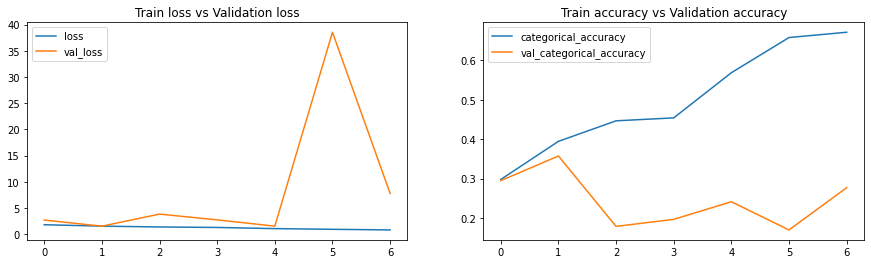

Max. Training Accuracy 0.6711309552192688
Max. Validaiton Accuracy 0.3571428656578064


In [ ]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(Set2_Model_4_History)

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : Set2_Model_4_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Conv3D Layer Kernel Size :',kernelsize)
print(color.TAB+'# MaxPool3D Pool Size : ', poolsize)
print(color.TAB+'# Total Params : 1,092,885')
print(color.TAB+'# Trainable Params : 1,092,533')
print(color.TAB+'# Non Trainable Params : 352')
print(color.TAB+"# Max. Training Accuracy :", max(Set2_Model_4_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Set2_Model_4_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : Set2_Model_4_History
	# No. of Frames :  30
	# Batch Size :  16
	# Image Dimensions : ( 120 , 120 )
	# No. of Epochs :  30
	# Conv3D Layer Kernel Size : (1, 3, 3)
	# MaxPool3D Pool Size :  (1, 2, 2)
	# Total Params : 1,092,885
	# Trainable Params : 1,092,533
	# Non Trainable Params : 352
	# Max. Training Accuracy : 0.6711309552192688
	# Max. Validaiton Accuracy : 0.3571428656578064


Drop in Training and Validation Loss and Accuracy, than what observed in Model 1 and 2
Loss Training and Validation Loss and Accuracy trending indicate model is overfitting

Decision: To check whether if we can Further Improve Loss and Accuracies, from what we have seen in Experiment 2.

###### Set 2 Model Architecture : Model 5
**Parameters same as New Experiment 5**

In [62]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv 3d Kernel Size, Max Pool 3d Pool Size
num_class=5
img_h, img_w=120,120
num_channels, s_frames, batch_size, num_epochs, lr_Rate, bias_init = 3, 30, 30, 30, 0, 0
neurons_density_1, neurons_density_2 = 32, 64
drop_out_1, drop_out_2 = 0.25, 0.25
kernelsize=(1,3,3)
poolsize=(1,2,2)

In [63]:
Set2_Model_5=Base_Model_2()
Set2_Model_5.project_path()
Set2_Model_5.init_properties(img_h,img_w)
Set2_Model_5.init_hyparams(s_frames, batch_size, num_epochs)
CNN_3d_set2_model_5=Set2_Model_5.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2, drop_out_1,drop_out_2,lr_Rate, bias_init)
CNN_3d_set2_model_5.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_66 (Conv3D)          (None, 30, 120, 120, 32)  12032     
                                                                 
 activation_66 (Activation)  (None, 30, 120, 120, 32)  0         
                                                                 
 max_pooling3d_66 (MaxPoolin  (None, 10, 40, 40, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_67 (Conv3D)          (None, 10, 40, 40, 64)    18496     
                                                                 
 activation_67 (Activation)  (None, 10, 40, 40, 64)    0         
                                                                 
 max_pooling3d_67 (MaxPoolin  (None, 10, 20, 20, 64)   0         
 g3D)                                                

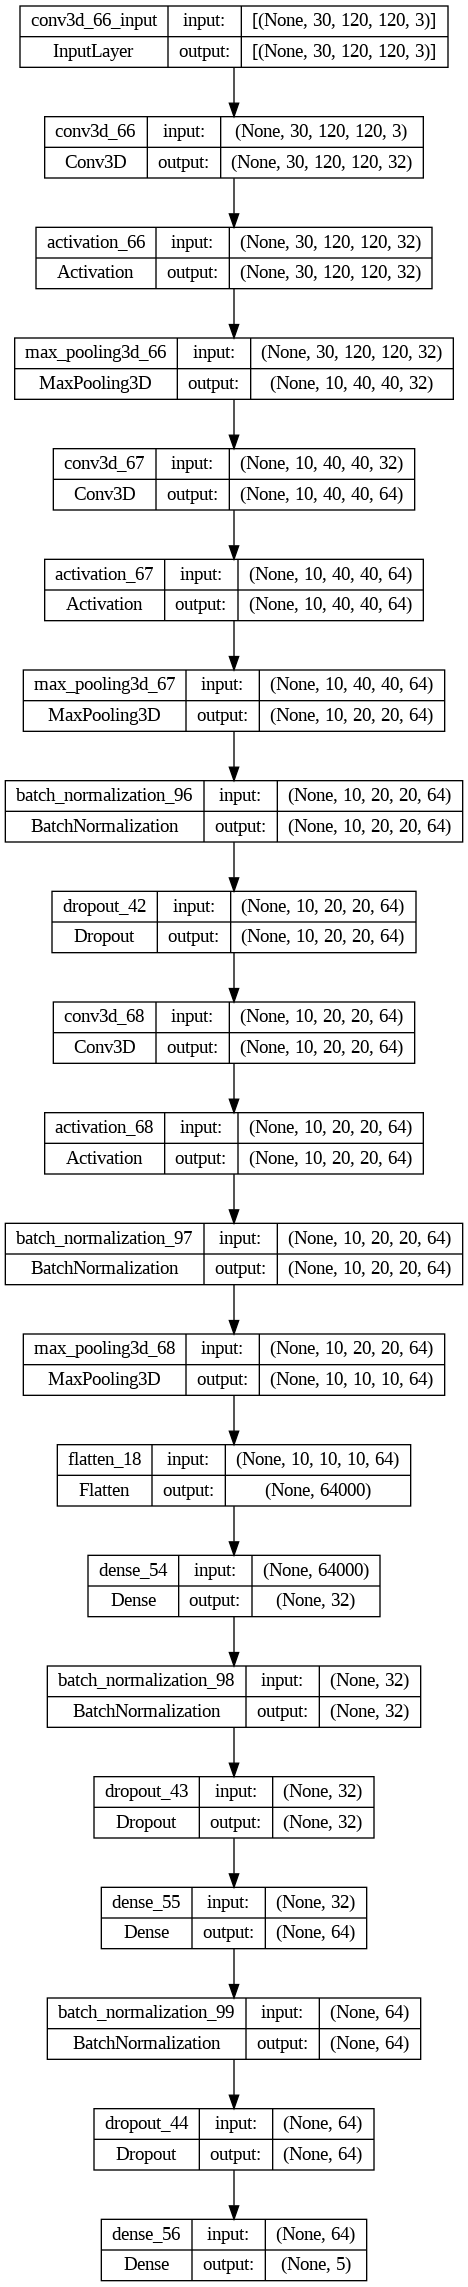

In [64]:
# Visualize the Model Architecture
plot_model(CNN_3d_set2_model_5, to_file='CNN_3d_set2_model_5.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Set 2 : Model 5 without Augment Data
Set2_Model_5_History=Set2_Model_5.create_model_tain(CNN_3d_set2_model_5)

Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.6961 - categorical_accuracy: 0.3551
Epoch 00001: saving model to model_init_2023-08-0702_06_13.615077/model-00001-1.69612-0.35507-1.88897-0.16667.h5
23/23 [==============================] - 171s 8s/step - loss: 1.6961 - categorical_accuracy: 0.3551 - val_loss: 1.8890 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.2490 - categorical_accuracy: 0.4754
Epoch 00002: saving model to model_init_2023-08-0702_06_13.615077/model-00002-1.24905-0.47536-1.33231-0.23333.h5
23/23 [==============================] - 169s 8s/step - loss: 1.2490 - categorical_accuracy: 0.4754 - val_loss: 1.3323 - val_categorical_accuracy: 0.2333 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.1039 - categorical_accuracy: 0.5275
Epoch 00003: saving model to model_init_2023-08-0702_06_13.615077/model-00003-1.10394-0.52754-1.28839-0.33333.h5
23/23 [==

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(Set2_Model_5_History.history)
hist_csv_file = 'Set2_Model_5_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

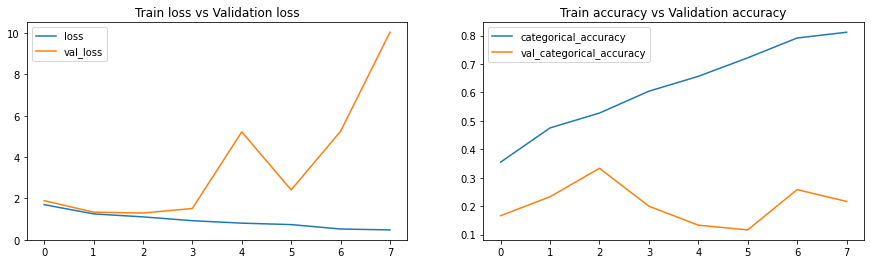

Max. Training Accuracy 0.8115941882133484
Max. Validaiton Accuracy 0.3333333432674408


In [ ]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(Set2_Model_5_History)

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : Set2_Model_5_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Conv3D Layer Kernel Size :',kernelsize)
print(color.TAB+'# MaxPool3D Pool Size : ', poolsize)
print(color.TAB+'# Total Params : 2,118,821')
print(color.TAB+'# Trainable Params : 2,118,373')
print(color.TAB+'# Non Trainable Params : 448')
print(color.TAB+"# Max. Training Accuracy :", max(Set2_Model_5_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Set2_Model_5_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : Set2_Model_5_History
	# No. of Frames :  30
	# Batch Size :  30
	# Image Dimensions : ( 120 , 120 )
	# No. of Epochs :  30
	# Conv3D Layer Kernel Size : (1, 3, 3)
	# MaxPool3D Pool Size :  (1, 2, 2)
	# Total Params : 2,118,821
	# Trainable Params : 2,118,373
	# Non Trainable Params : 448
	# Max. Training Accuracy : 0.8115941882133484
	# Max. Validaiton Accuracy : 0.3333333432674408


Drop in Training and Validation Loss and Accuracy, than what observed in Model 1 and 2
Loss Training and Validation Loss and Accuracy trending indicate model is overfitting

Decision: To check whether if we can Further Improve Loss and Accuracies, from what we have seen in Experiment 2.

###### Set 2 Experiment Model Architecture : Model 6
**Same Parameters as New Experiment 5, but with Augment Data**

In [ ]:
# Set 2 : Model 6 with Augment Data
# Set2_Model_6_History=Set2_Model_5.create_model_tain(CNN_3d_set2_model_5, augment_data=True)

**Encountered Error - "2023-08-07 02:36:41.255741: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.09GiB (rounded to 3317760000)requested by op gradient_tape/sequential_1/max_pooling3d_3/MaxPool3D/MaxPool3DGrad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation.".**

**Lets Try by Reducing the batch Size and Image Dimensions**

In [65]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv 3d Kernel Size, Max Pool 3d Pool Size
num_class=5
img_h, img_w=100,100
num_channels, s_frames, batch_size, num_epochs, lr_Rate, bias_init = 3, 30, 16, 30, 0, 0
neurons_density_1, neurons_density_2 = 32, 64
drop_out_1, drop_out_2 = 0.25, 0.25
kernelsize=(1,3,3)
poolsize=(1,2,2)

In [66]:
Set2_Model_6=Base_Model_2()
Set2_Model_6.project_path()
Set2_Model_6.init_properties(img_h,img_w)
Set2_Model_6.init_hyparams(s_frames, batch_size, num_epochs)
CNN_3d_set2_model_6=Set2_Model_6.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2, drop_out_1,drop_out_2,lr_Rate, bias_init)
CNN_3d_set2_model_6.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_69 (Conv3D)          (None, 30, 100, 100, 32)  12032     
                                                                 
 activation_69 (Activation)  (None, 30, 100, 100, 32)  0         
                                                                 
 max_pooling3d_69 (MaxPoolin  (None, 10, 34, 34, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_70 (Conv3D)          (None, 10, 34, 34, 64)    18496     
                                                                 
 activation_70 (Activation)  (None, 10, 34, 34, 64)    0         
                                                                 
 max_pooling3d_70 (MaxPoolin  (None, 10, 17, 17, 64)   0         
 g3D)                                                

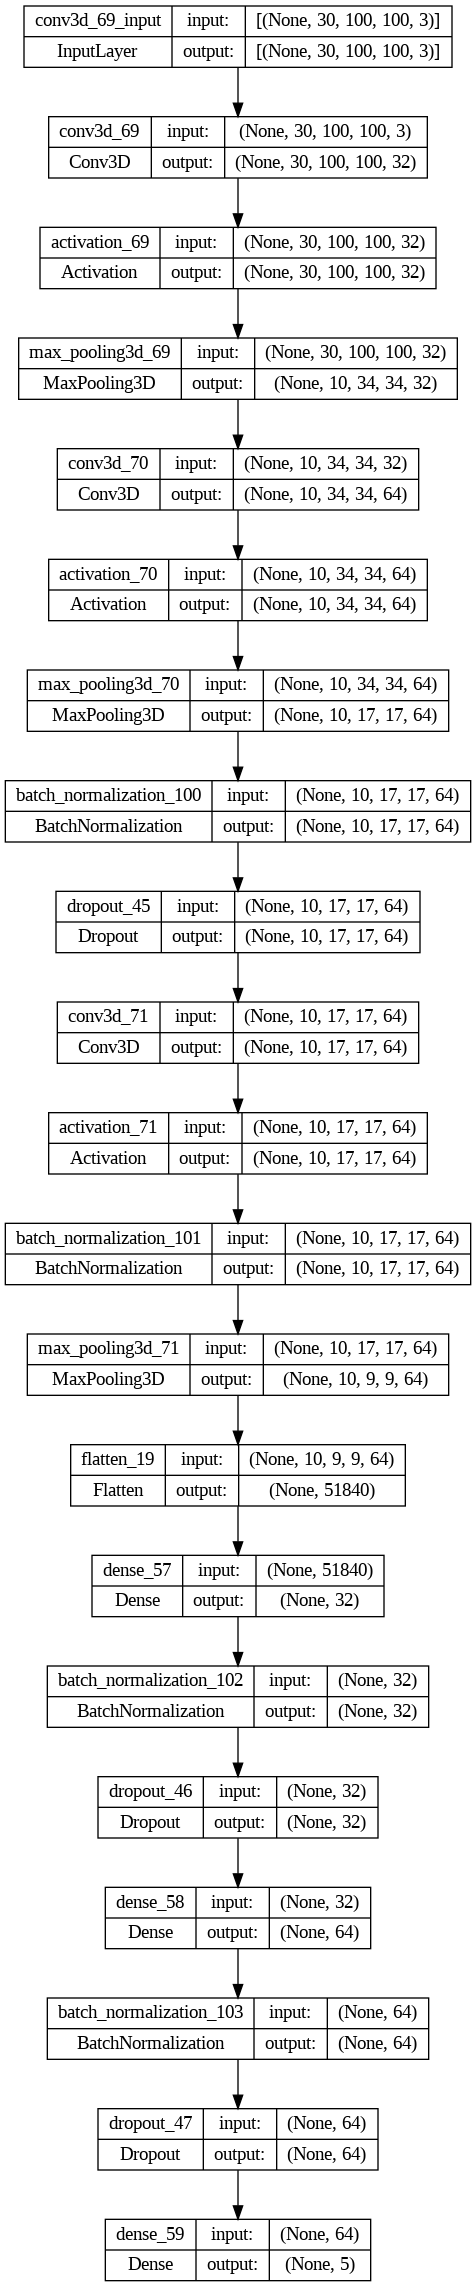

In [67]:
# Visualize the Model Architecture
plot_model(CNN_3d_set2_model_6, to_file='CNN_3d_set2_model_6.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Set 2 : Model 6 with Augment Data
Set2_Model_6_History=Set2_Model_6.create_model_tain(CNN_3d_set2_model_6, augment_data=True)

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.7395 - categorical_accuracy: 0.3162
Epoch 00001: saving model to model_init_2023-08-0703_23_39.003242/model-00001-1.73949-0.31622-1.49827-0.15179.h5
42/42 [==============================] - 314s 8s/step - loss: 1.7395 - categorical_accuracy: 0.3162 - val_loss: 1.4983 - val_categorical_accuracy: 0.1518 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.3500 - categorical_accuracy: 0.4420
Epoch 00002: saving model to model_init_2023-08-0703_23_39.003242/model-00002-1.35000-0.44196-2.24619-0.26786.h5
42/42 [==============================] - 325s 8s/step - loss: 1.3500 - categorical_accuracy: 0.4420 - val_loss: 2.2462 - val_categorical_accuracy: 0.2679 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.1279 - categorical_accuracy: 0.5149
Epoch 00003: saving model to model_init_2023-08-0703_23_39.003242/model-00003-1.12785-0.51488-3.50478-0.29464.h5
42/42 [==

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(Set2_Model_6_History.history)
hist_csv_file = 'Set2_Model_6_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

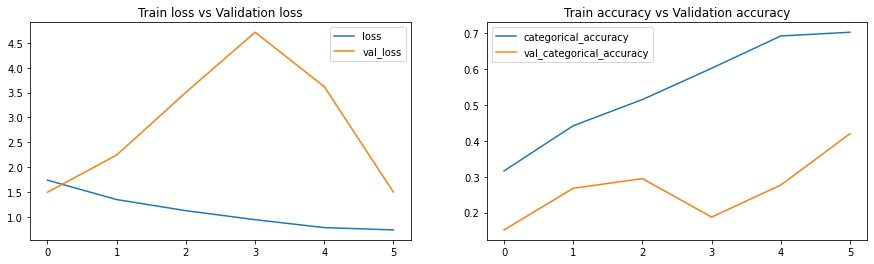

Max. Training Accuracy 0.7023809552192688
Max. Validaiton Accuracy 0.4196428656578064


In [ ]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(Set2_Model_6_History)

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : Set2_Model_6_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Conv3D Layer Kernel Size :',kernelsize)
print(color.TAB+'# MaxPool3D Pool Size : ', poolsize)
print(color.TAB+'# Total Params : 1,729,701')
print(color.TAB+'# Trainable Params :1,729,253')
print(color.TAB+'# Non Trainable Params : 448')
print(color.TAB+"# Max. Training Accuracy :", max(Set2_Model_6_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Set2_Model_6_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : Set2_Model_6_History
	# No. of Frames :  30
	# Batch Size :  16
	# Image Dimensions : ( 100 , 100 )
	# No. of Epochs :  30
	# Conv3D Layer Kernel Size : (1, 3, 3)
	# MaxPool3D Pool Size :  (1, 2, 2)
	# Total Params : 1,729,701
	# Trainable Params :1,729,253
	# Non Trainable Params : 448
	# Max. Training Accuracy : 0.7023809552192688
	# Max. Validaiton Accuracy : 0.4196428656578064


###### Set 2 Experiment Model Architecture : Model 7
**Parameters Same as New Experiment Model 7**

In [68]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv 3d Kernel Size, Max Pool 3d Pool Size
num_class=5
img_h, img_w=100,100
num_channels, s_frames, batch_size, num_epochs, lr_Rate, bias_init = 3, 30, 30, 25, 0, 0
neurons_density_1, neurons_density_2 = 32, 64
drop_out_1, drop_out_2 = 0.25, 0.5
kernelsize=(1,3,3)
poolsize=(1,2,2)

In [69]:
Set2_Model_7=Base_Model_2()
Set2_Model_7.project_path()
Set2_Model_7.init_properties(img_h,img_w)
Set2_Model_7.init_hyparams(s_frames, batch_size, num_epochs)
CNN_3d_set2_model_7=Set2_Model_7.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2, drop_out_1,drop_out_2,lr_Rate, bias_init)
CNN_3d_set2_model_7.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_72 (Conv3D)          (None, 30, 100, 100, 32)  12032     
                                                                 
 activation_72 (Activation)  (None, 30, 100, 100, 32)  0         
                                                                 
 max_pooling3d_72 (MaxPoolin  (None, 10, 34, 34, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_73 (Conv3D)          (None, 10, 34, 34, 64)    18496     
                                                                 
 activation_73 (Activation)  (None, 10, 34, 34, 64)    0         
                                                                 
 max_pooling3d_73 (MaxPoolin  (None, 10, 17, 17, 64)   0         
 g3D)                                                

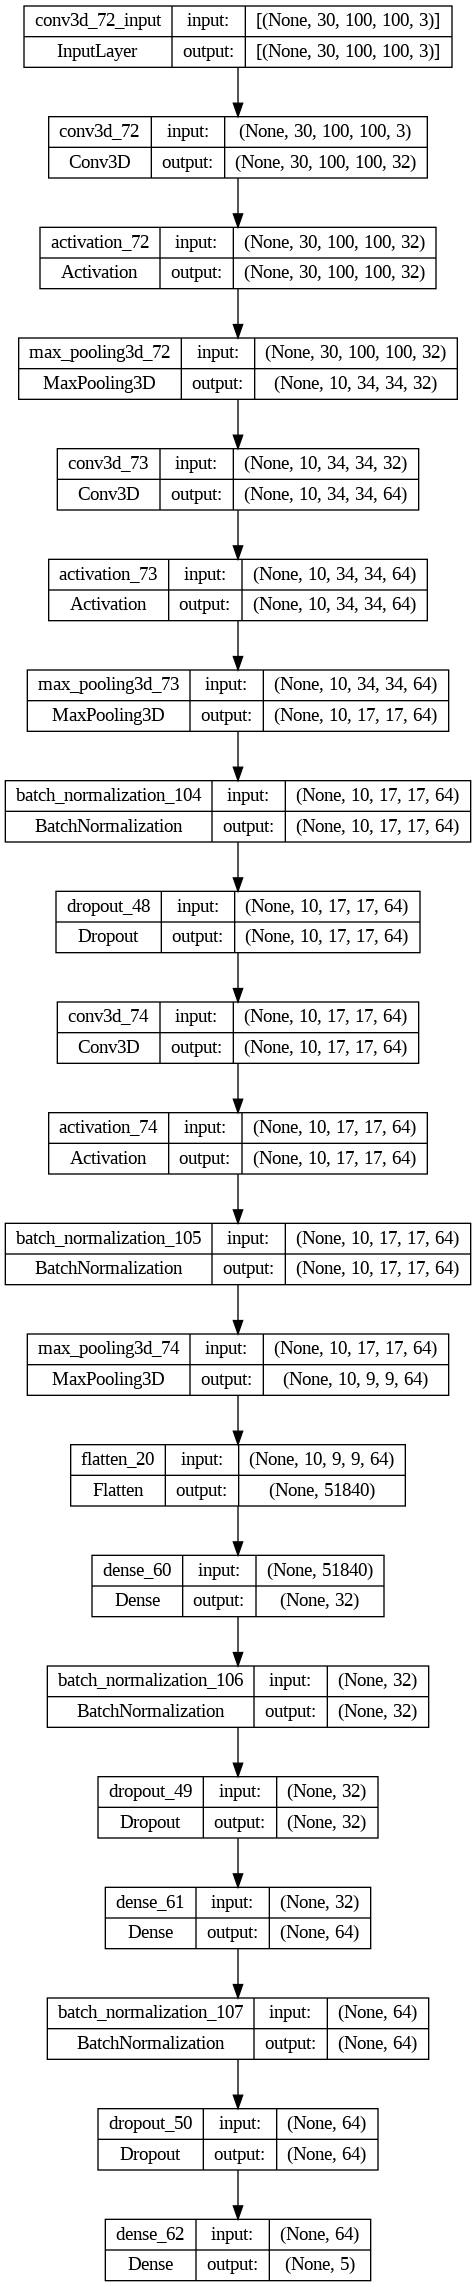

In [70]:
# Visualize the Model Architecture
plot_model(CNN_3d_set2_model_7, to_file='CNN_3d_set2_model_7.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Set 2 : Model 7 without Augment Data
Set2_Model_7_History=Set2_Model_7.create_model_tain(CNN_3d_set2_model_7)

Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.0595 - categorical_accuracy: 0.2725
Epoch 00001: saving model to model_init_2023-08-0703_55_34.616694/model-00001-2.05954-0.27246-1.58198-0.41667.h5
23/23 [==============================] - 168s 7s/step - loss: 2.0595 - categorical_accuracy: 0.2725 - val_loss: 1.5820 - val_categorical_accuracy: 0.4167 - lr: 0.0010
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.8340 - categorical_accuracy: 0.2957
Epoch 00002: saving model to model_init_2023-08-0703_55_34.616694/model-00002-1.83404-0.29565-1.61611-0.26667.h5
23/23 [==============================] - 176s 8s/step - loss: 1.8340 - categorical_accuracy: 0.2957 - val_loss: 1.6161 - val_categorical_accuracy: 0.2667 - lr: 0.0010
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.7483 - categorical_accuracy: 0.3565
Epoch 00003: saving model to model_init_2023-08-0703_55_34.616694/model-00003-1.74831-0.35652-1.36022-0.29167.h5
23/23 [==

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(Set2_Model_7_History.history)
hist_csv_file = 'Set2_Model_7_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

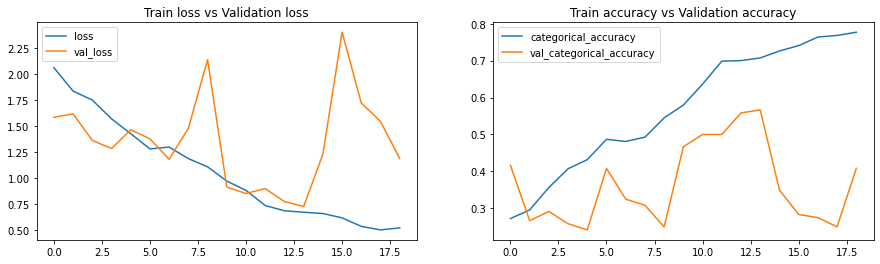

Max. Training Accuracy 0.7768115997314453
Max. Validaiton Accuracy 0.5666666626930237


In [ ]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(Set2_Model_7_History)

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : Set2_Model_7_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Conv3D Layer Kernel Size :',kernelsize)
print(color.TAB+'# MaxPool3D Pool Size : ', poolsize)
print(color.TAB+'# Total Params : 1,729,701')
print(color.TAB+'# Trainable Params : 1,729,253')
print(color.TAB+'# Non Trainable Params : 448')
print(color.TAB+"# Max. Training Accuracy :", max(Set2_Model_7_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Set2_Model_7_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : Set2_Model_7_History
	# No. of Frames :  30
	# Batch Size :  30
	# Image Dimensions : ( 100 , 100 )
	# No. of Epochs :  25
	# Conv3D Layer Kernel Size : (1, 3, 3)
	# MaxPool3D Pool Size :  (1, 2, 2)
	# Total Params : 1,729,701
	# Trainable Params : 1,729,253
	# Non Trainable Params : 448
	# Max. Training Accuracy : 0.7768115997314453
	# Max. Validaiton Accuracy : 0.5666666626930237


###### Set 2 Experiment Model Architecture : Model 8
**Parameters same as New Experiment 7, but with Augment Data**

In [ ]:
# Set 2 : Model 8 without Augment Data
Set2_Model_8_History=Set2_Model_7.create_model_tain(CNN_3d_set2_model_7)

Epoch 1/25


2023-08-07 19:49:28.877138: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 2.2386 - categorical_accuracy: 0.2565
Epoch 00001: saving model to model_init_2023-08-0719_49_20.776671/model-00001-2.23863-0.25652-1.61765-0.19167.h5
23/23 [==============================] - 156s 7s/step - loss: 2.2386 - categorical_accuracy: 0.2565 - val_loss: 1.6176 - val_categorical_accuracy: 0.1917 - lr: 0.0010
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.8504 - categorical_accuracy: 0.3348
Epoch 00002: saving model to model_init_2023-08-0719_49_20.776671/model-00002-1.85041-0.33478-1.25629-0.38333.h5
23/23 [==============================] - 162s 7s/step - loss: 1.8504 - categorical_accuracy: 0.3348 - val_loss: 1.2563 - val_categorical_accuracy: 0.3833 - lr: 0.0010
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.7183 - categorical_accuracy: 0.3464
Epoch 00003: saving model to model_init_2023-08-0719_49_20.776671/model-00003-1.71834-0.34638-1.56653-0.32500.h5
23/23 [=============

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(Set2_Model_8_History.history)
hist_csv_file = 'Set2_Model_8_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

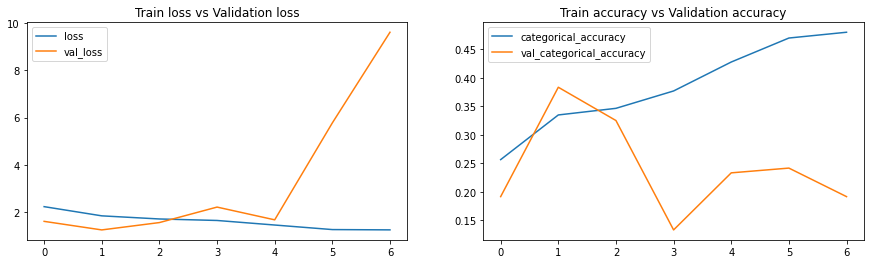

Max. Training Accuracy 0.4797101318836212
Max. Validaiton Accuracy 0.38333332538604736


In [ ]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(Set2_Model_8_History)

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : Set2_Model_8_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Conv3D Layer Kernel Size :',kernelsize)
print(color.TAB+'# MaxPool3D Pool Size : ', poolsize)
print(color.TAB+'# Total Params : 1,729,701')
print(color.TAB+'# Trainable Params : 1,729,253')
print(color.TAB+'# Non Trainable Params : 448')
print(color.TAB+"# Max. Training Accuracy :", max(Set2_Model_8_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Set2_Model_8_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : Set2_Model_8_History
	# No. of Frames :  30
	# Batch Size :  30
	# Image Dimensions : ( 100 , 100 )
	# No. of Epochs :  25
	# Conv3D Layer Kernel Size : (1, 3, 3)
	# MaxPool3D Pool Size :  (1, 2, 2)
	# Total Params : 1,729,701
	# Trainable Params : 1,729,253
	# Non Trainable Params : 448
	# Max. Training Accuracy : 0.4797101318836212
	# Max. Validaiton Accuracy : 0.38333332538604736


Callback Early Stopping at Epoch 7.

Training and Validation Loss Plot indicates model tending to over-fit. show and Accuracy, trending better but the training parameters are much higher than the Model1 and Model 2

Decision: To check whether if we can Further Improve Loss and Accuracies, from what we have seen in Experiment 2.

###### Set 2 Experiment Model Architecture : Model 9
**Using the parameters for Model 2, with increase in Epoch and batch size**

In [71]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv 3d Kernel Size, Max Pool 3d Pool Size
num_class=5
img_h, img_w=100,100
num_channels, s_frames, batch_size, num_epochs, lr_Rate, bias_init = 3, 30, 20, 40,0, 0
neurons_density_1, neurons_density_2 = 16, 32
drop_out_1, drop_out_2 = 0.25, 0.25
kernelsize=(1,3,3)
poolsize=(1,2,2)

In [72]:
Set2_Model_9=Base_Model_2()
Set2_Model_9.project_path()
Set2_Model_9.init_properties(img_h,img_w)
Set2_Model_9.init_hyparams(s_frames, batch_size, num_epochs)
CNN_3d_set2_model_9=Set2_Model_9.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2, drop_out_1,drop_out_2,lr_Rate, bias_init)
CNN_3d_set2_model_9.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_75 (Conv3D)          (None, 30, 100, 100, 32)  12032     
                                                                 
 activation_75 (Activation)  (None, 30, 100, 100, 32)  0         
                                                                 
 max_pooling3d_75 (MaxPoolin  (None, 10, 34, 34, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_76 (Conv3D)          (None, 10, 34, 34, 64)    18496     
                                                                 
 activation_76 (Activation)  (None, 10, 34, 34, 64)    0         
                                                                 
 max_pooling3d_76 (MaxPoolin  (None, 10, 17, 17, 64)   0         
 g3D)                                                

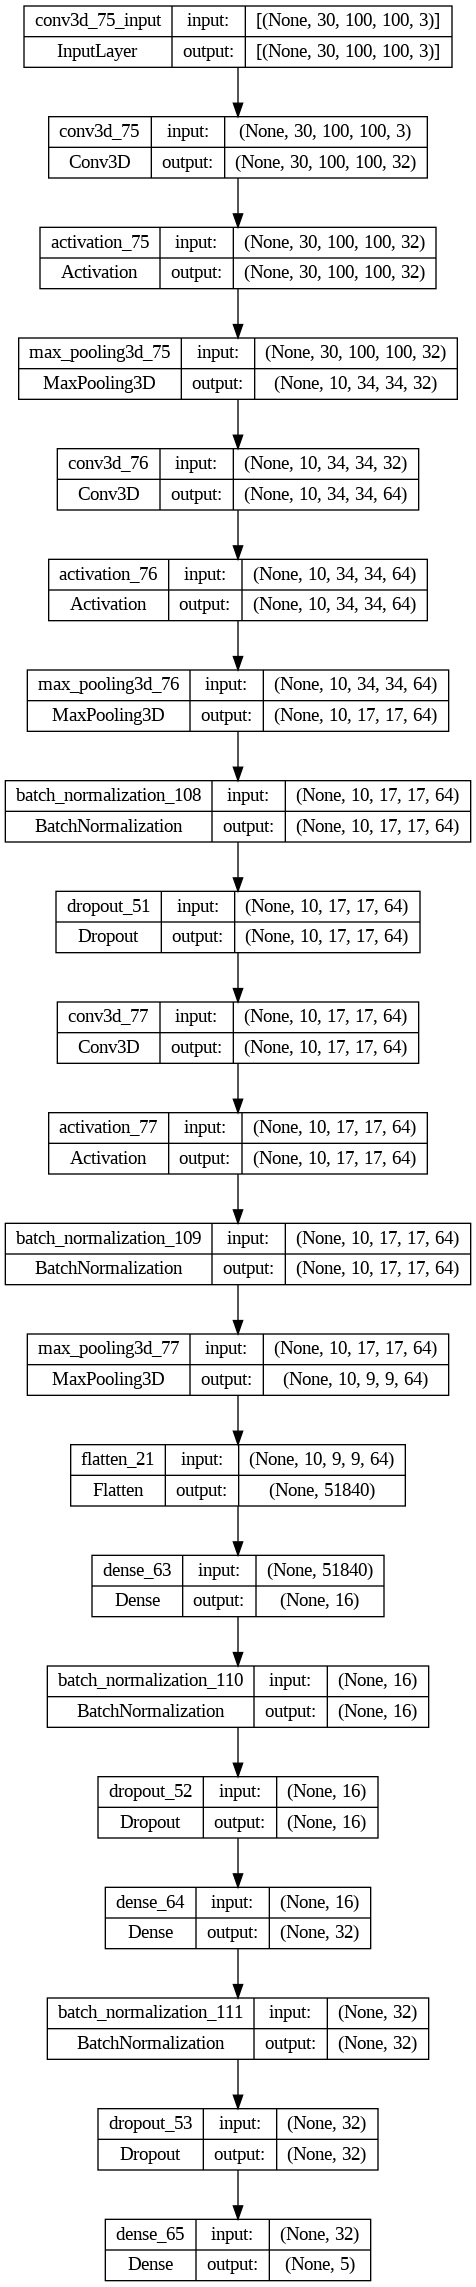

In [73]:
# Visualize the Model Architecture
plot_model(CNN_3d_set2_model_9, to_file='CNN_3d_set2_model_9.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Set 2 : Model 9 without Augment Data
Set2_Model_9_History=Set2_Model_9.create_model_tain(CNN_3d_set2_model_9, augment_data=True)

Epoch 1/40


2023-08-08 00:07:55.011336: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.8004 - categorical_accuracy: 0.3125
Epoch 00001: saving model to model_init_2023-08-0800_07_44.540972/model-00001-1.80044-0.31250-1.66063-0.26000.h5
34/34 [==============================] - 274s 8s/step - loss: 1.8004 - categorical_accuracy: 0.3125 - val_loss: 1.6606 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/40
34/34 [==============================] - ETA: 0s - loss: 1.5139 - categorical_accuracy: 0.3743
Epoch 00002: saving model to model_init_2023-08-0800_07_44.540972/model-00002-1.51393-0.37426-2.02577-0.18000.h5
34/34 [==============================] - 270s 8s/step - loss: 1.5139 - categorical_accuracy: 0.3743 - val_loss: 2.0258 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/40
34/34 [==============================] - ETA: 0s - loss: 1.4597 - categorical_accuracy: 0.3912
Epoch 00003: saving model to model_init_2023-08-0800_07_44.540972/model-00003-1.45968-0.39118-9.75205-0.19000.h5
34/34 [=============

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(Set2_Model_9_History.history)
hist_csv_file = 'Set2_Model_9_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

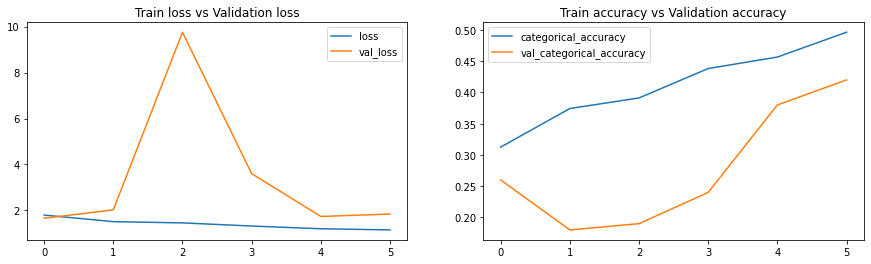

Max. Training Accuracy 0.49632352590560913
Max. Validaiton Accuracy 0.41999998688697815


In [ ]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(Set2_Model_9_History)

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : Set2_Model_9_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Conv3D Layer Kernel Size :',kernelsize)
print(color.TAB+'# MaxPool3D Pool Size : ', poolsize)
print(color.TAB+'# Total Params : 898,325')
print(color.TAB+'# Trainable Params : 897,973')
print(color.TAB+'# Non Trainable Params : 352')
print(color.TAB+"# Max. Training Accuracy :", max(Set2_Model_9_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Set2_Model_9_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : Set2_Model_9_History
	# No. of Frames :  30
	# Batch Size :  20
	# Image Dimensions : ( 100 , 100 )
	# No. of Epochs :  40
	# Conv3D Layer Kernel Size : (1, 3, 3)
	# MaxPool3D Pool Size :  (1, 2, 2)
	# Total Params : 898,325
	# Trainable Params : 897,973
	# Non Trainable Params : 352
	# Max. Training Accuracy : 0.49632352590560913
	# Max. Validaiton Accuracy : 0.41999998688697815


###### Set 2 Experiment Model Architecture : Model 10
**Using GlobalAveragePool3D instead of Flatten**

In [74]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv 3d Kernel Size, Max Pool 3d Pool Size
num_class=5
img_h, img_w=100,100
num_channels, s_frames, batch_size, num_epochs, lr_Rate, bias_init = 3, 30, 16, 40,0, 0
neurons_density_1, neurons_density_2 = 16, 32
drop_out_1, drop_out_2 = 0.25, 0.25
kernelsize=(1,3,3)
poolsize=(1,2,2)

In [75]:
class Base_Model_2(BuildModel):
    num_class=5
    seq_idx = get_seq_idx(s_frames)
    s_frames=len(seq_idx)
    def define_model(self,num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2,drop_out_1,drop_out_2,lr_Rate, bias_init):

        model = Sequential()
        model.add(Conv3D(32, make3dFilter(5), padding='same',
                 input_shape=(s_frames,img_h,self.img_w,num_channels)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(make3dFilter(3),padding='same'))

        model.add(Conv3D(64, kernelsize, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=poolsize, padding='same'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out_1))

        model.add(Conv3D(128, kernelsize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=poolsize, padding='same'))

        model.add(GlobalAveragePooling3D())
        model.add(Dense(neurons_density_1,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out_2))

        model.add(Dense(neurons_density_2,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out_2))


        model.add(Dense(self.num_class,activation='softmax'))

        if lr_Rate != 0:
          optimiser = optimizers.Adam(lr=lr_Rate)
        else:
          optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [76]:
Set2_Model_10=Base_Model_2()
Set2_Model_10.project_path()
Set2_Model_10.init_properties(img_h,img_w)
Set2_Model_10.init_hyparams(s_frames, batch_size, num_epochs)
CNN_3d_set2_model_10=Set2_Model_10.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2, drop_out_1,drop_out_2,lr_Rate, bias_init)
CNN_3d_set2_model_10.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_78 (Conv3D)          (None, 30, 100, 100, 32)  12032     
                                                                 
 activation_78 (Activation)  (None, 30, 100, 100, 32)  0         
                                                                 
 max_pooling3d_78 (MaxPoolin  (None, 10, 34, 34, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_79 (Conv3D)          (None, 10, 34, 34, 64)    18496     
                                                                 
 activation_79 (Activation)  (None, 10, 34, 34, 64)    0         
                                                                 
 max_pooling3d_79 (MaxPoolin  (None, 10, 17, 17, 64)   0         
 g3D)                                                

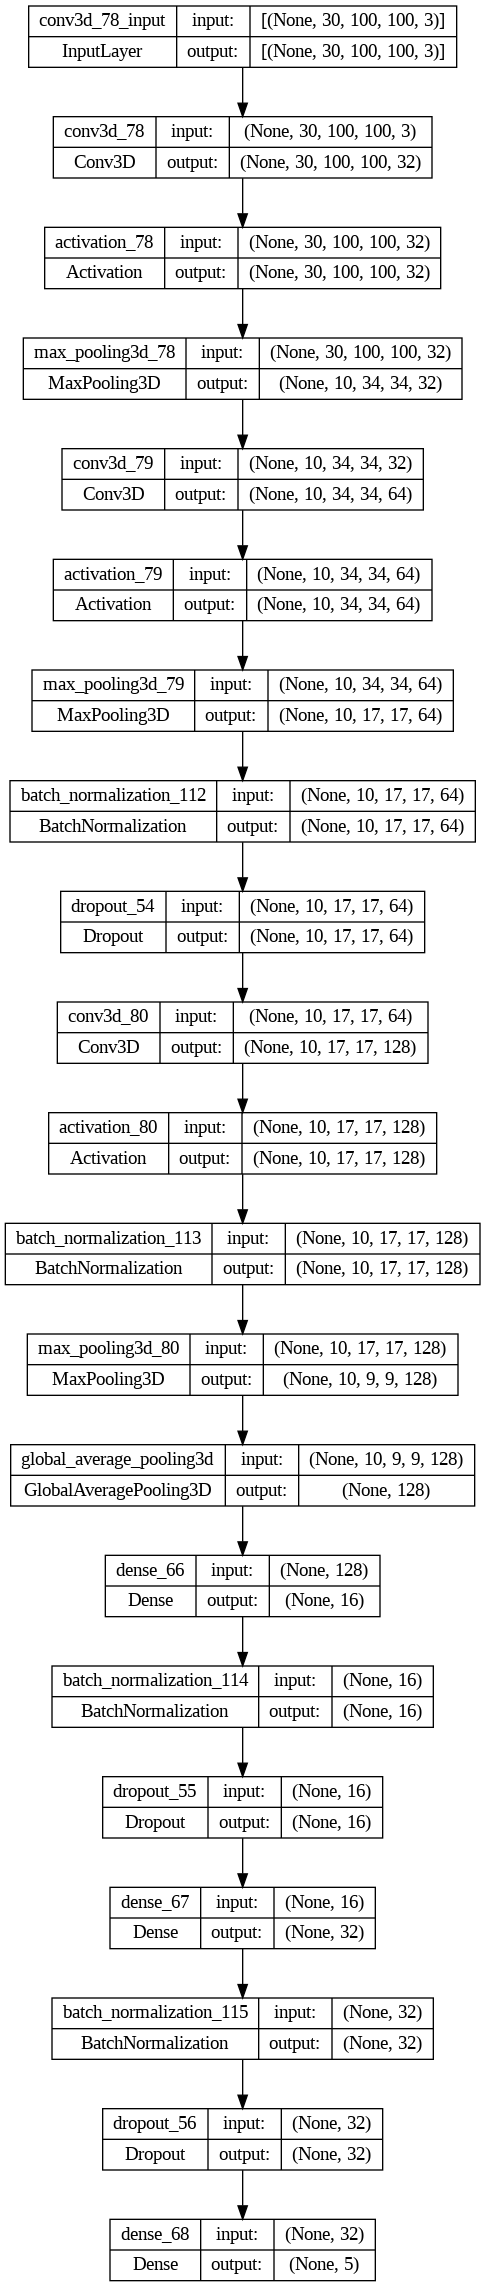

In [77]:
# Visualize the Model Architecture
plot_model(CNN_3d_set2_model_10, to_file='CNN_3d_set2_model_10.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Set 2 : Model 9 with Augment Data
Set2_Model_10_History=Set2_Model_10.create_model_tain(CNN_3d_set2_model_10)

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.6720 - categorical_accuracy: 0.3095
Epoch 00001: saving model to model_init_2023-08-0720_41_34.476317/model-00001-1.67201-0.30952-1.69060-0.20536.h5
42/42 [==============================] - 155s 4s/step - loss: 1.6720 - categorical_accuracy: 0.3095 - val_loss: 1.6906 - val_categorical_accuracy: 0.2054 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.5005 - categorical_accuracy: 0.3318
Epoch 00002: saving model to model_init_2023-08-0720_41_34.476317/model-00002-1.50048-0.33185-1.66838-0.19643.h5
42/42 [==============================] - 154s 4s/step - loss: 1.5005 - categorical_accuracy: 0.3318 - val_loss: 1.6684 - val_categorical_accuracy: 0.1964 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.3655 - categorical_accuracy: 0.4345
Epoch 00003: saving model to model_init_2023-08-0720_41_34.476317/model-00003-1.36553-0.43452-1.35511-0.33929.h5
42/42 [==

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(Set2_Model_10_History.history)
hist_csv_file = 'Set2_Model_10_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

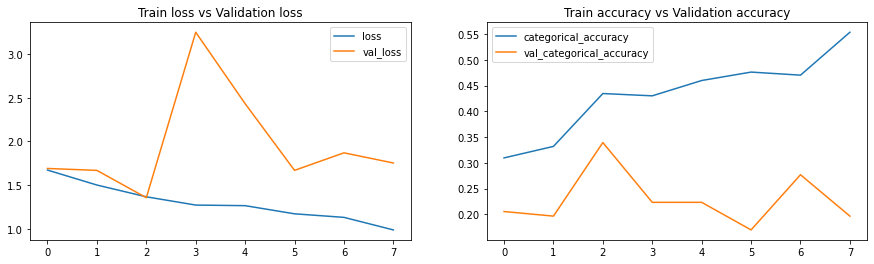

Max. Training Accuracy 0.5535714030265808
Max. Validaiton Accuracy 0.3392857015132904


In [ ]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(Set2_Model_10_History)

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : Set2_Model_10_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Conv3D Layer Kernel Size :',kernelsize)
print(color.TAB+'# MaxPool3D Pool Size : ', poolsize)
print(color.TAB+'# Total Params : 108,117')
print(color.TAB+'# Trainable Params : 107,637')
print(color.TAB+'# Non Trainable Params : 480')
print(color.TAB+"# Max. Training Accuracy :", max(Set2_Model_10_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Set2_Model_10_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : Set2_Model_8_History
	# No. of Frames :  30
	# Batch Size :  16
	# Image Dimensions : ( 100 , 100 )
	# No. of Epochs :  30
	# Conv3D Layer Kernel Size : (1, 3, 3)
	# MaxPool3D Pool Size :  (1, 2, 2)
	# Total Params : 108,117
	# Trainable Params : 107,637
	# Non Trainable Params : 480
	# Max. Training Accuracy : 0.5535714030265808
	# Max. Validaiton Accuracy : 0.3392857015132904


Callback Early Stopping at Epoch 8.

Training and Validation Loss and Accuracy trend indicates model tending to Over-Fit.

Decision: To check whether if we can Further Improve Loss and Accuracies, from what we have seen in Experiment 2.


###### Set 2 Experient Model Architecture : Model 11
**Same Parameters as Model 10, but with Augment Data**

In [ ]:
# Set 2 : Model 11 with Augment Data
Set2_Model_11_History=Set2_Model_10.create_model_tain(CNN_3d_set2_model_10, augment_data=True)

Epoch 1/40
42/42 [==============================] - ETA: 0s - loss: 1.7346 - categorical_accuracy: 0.3080
Epoch 00001: saving model to model_init_2023-08-0800_38_47.163265/model-00001-1.73463-0.30804-1.59289-0.18750.h5
42/42 [==============================] - 273s 7s/step - loss: 1.7346 - categorical_accuracy: 0.3080 - val_loss: 1.5929 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/40
42/42 [==============================] - ETA: 0s - loss: 1.5038 - categorical_accuracy: 0.3713
Epoch 00002: saving model to model_init_2023-08-0800_38_47.163265/model-00002-1.50382-0.37128-1.58097-0.14286.h5
42/42 [==============================] - 272s 7s/step - loss: 1.5038 - categorical_accuracy: 0.3713 - val_loss: 1.5810 - val_categorical_accuracy: 0.1429 - lr: 0.0010
Epoch 3/40
42/42 [==============================] - ETA: 0s - loss: 1.3735 - categorical_accuracy: 0.4025
Epoch 00003: saving model to model_init_2023-08-0800_38_47.163265/model-00003-1.37348-0.40253-1.47192-0.28571.h5
42/42 [==

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(Set2_Model_11_History.history)
hist_csv_file = 'Set2_Model_11_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

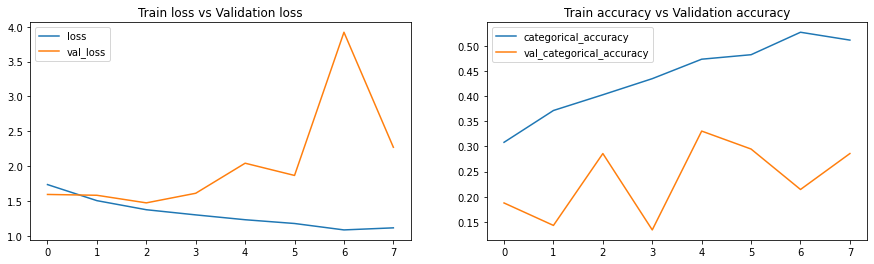

Max. Training Accuracy 0.5267857313156128
Max. Validaiton Accuracy 0.3303571343421936


In [ ]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(Set2_Model_11_History)

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : Set2_Model_11_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Conv3D Layer Kernel Size :',kernelsize)
print(color.TAB+'# MaxPool3D Pool Size : ', poolsize)
print(color.TAB+'# Total Params : 108,117')
print(color.TAB+'# Trainable Params : 107,637')
print(color.TAB+'# Non Trainable Params : 480')
print(color.TAB+"# Max. Training Accuracy :", max(Set2_Model_11_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(Set2_Model_11_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : Set2_Model_11_History
	# No. of Frames :  30
	# Batch Size :  16
	# Image Dimensions : ( 100 , 100 )
	# No. of Epochs :  40
	# Conv3D Layer Kernel Size : (1, 3, 3)
	# MaxPool3D Pool Size :  (1, 2, 2)
	# Total Params : 108,117
	# Trainable Params : 107,637
	# Non Trainable Params : 480
	# Max. Training Accuracy : 0.5267857313156128
	# Max. Validaiton Accuracy : 0.3303571343421936


In [ ]:
Result similar to Model 10.

Stopping the creating more models with Conv 3D.


#### CNN3D Set 2 Model Architecture : Model 2 has the best Loss and Accuracy Score.

# Conv2D + RNN
**Conv 2d + RNN Models**

#### Conv 2D + LSTM : Model 1

In [17]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv 3d Kernel Size, Max Pool 3d Pool Size
num_class=5
img_h, img_w=100,100
num_channels, s_frames, batch_size, num_epochs, lstm_n = 3, 30, 30, 40, 32
neurons_density_1, neurons_density_2 = 32, 32
drop_out_1, drop_out_2 = 0.25, 0.25
kernelsize=(3,3)
poolsize=(2,2)

In [18]:
class Conv2d_RNN_1(BuildModel):

    def define_model(self,num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2,drop_out_1,drop_out_2, lstm_n):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(32,kernelsize, padding='same', activation='relu'),
                                  input_shape=(s_frames,img_h,img_w,num_channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(poolsize)))

        model.add(TimeDistributed(Conv2D(32, kernelsize , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(poolsize)))

        model.add(TimeDistributed(Conv2D(64, kernelsize , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(poolsize)))
        model.add(Dropout(drop_out_1))

        model.add(TimeDistributed(Conv2D(128, kernelsize , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(poolsize)))

        #model.add(TimeDistributed(Conv2D(256, kernelsize , padding='same', activation='relu')))
        #model.add(TimeDistributed(BatchNormalization()))
        #model.add(TimeDistributed(MaxPooling2D(poolsize)))


        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_n))
        model.add(Dropout(drop_out_2))

        model.add(Dense(neurons_density_1,activation='relu'))
        model.add(Dropout(drop_out_2))

        model.add(Dense(num_class, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
CNN2D_Model_1=Conv2d_RNN_1()
CNN2D_Model_1.project_path()
CNN2D_Model_1.init_properties(img_h,img_w)
CNN2D_Model_1.init_hyparams(s_frames, batch_size, num_epochs)
CNN_2d_LSTM_model_1=CNN2D_Model_1.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2, drop_out_1,drop_out_2,lstm_n)
CNN_2d_LSTM_model_1.summary()

2023-08-09 14:43:27.150044: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 100, 100, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 100, 100, 32)  128      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 50, 50, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 50, 50, 32)   9248      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 50, 50, 32)   1

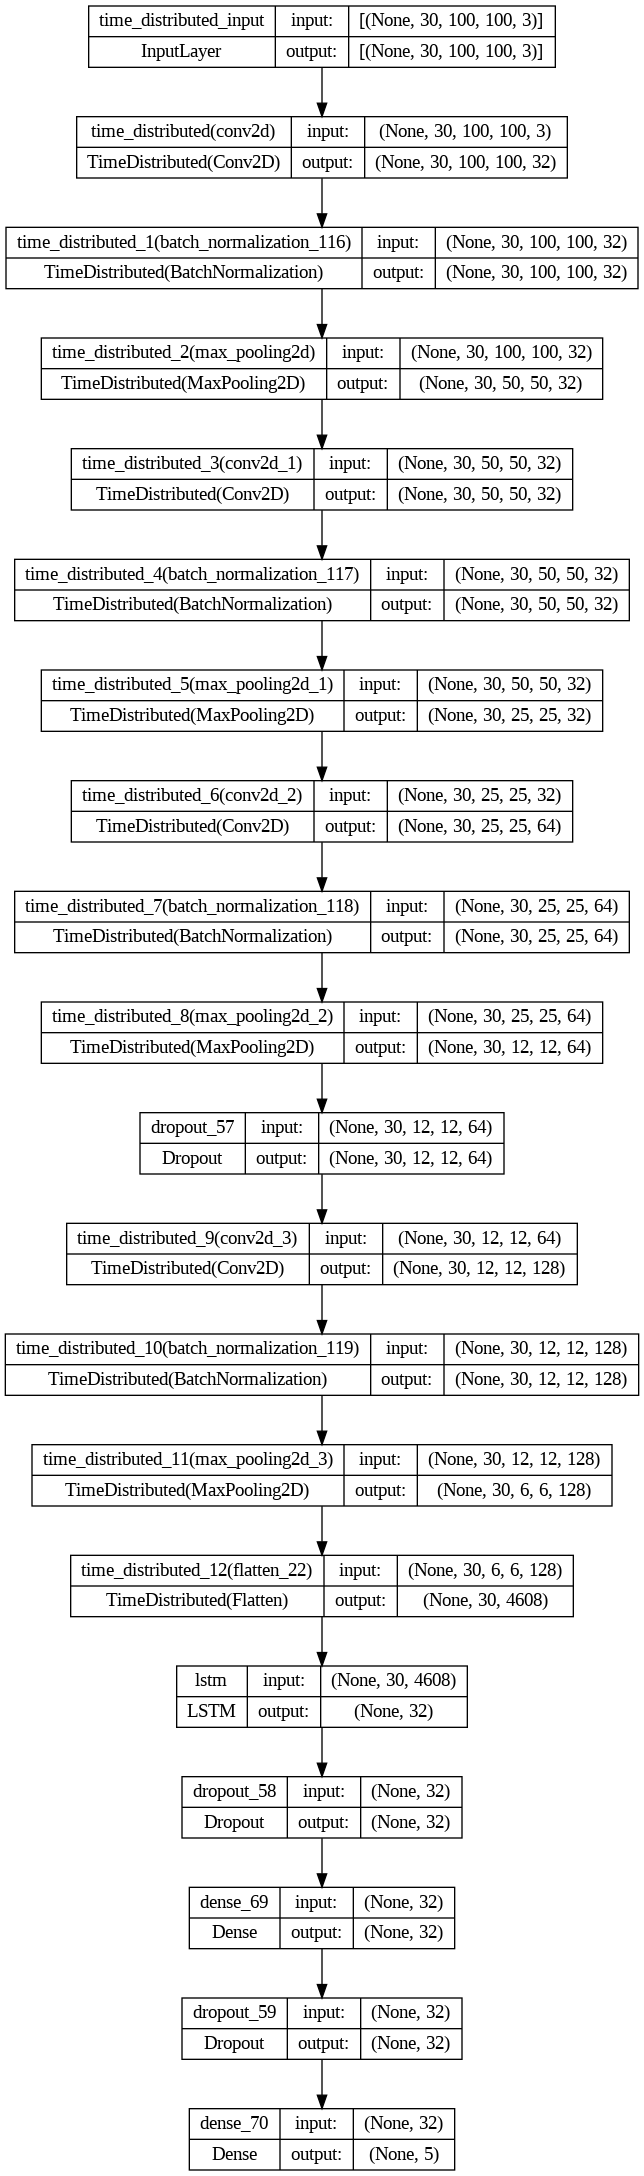

In [82]:
# Visualize the Model Architecture
plot_model(CNN_2d_LSTM_model_1, to_file='CNN_2d_LSTM_model_1.png', show_shapes=True, show_layer_names=True)

In [24]:
# CNN2D Model without Augment Data
CNN2D_Model_1_History=CNN2D_Model_1.create_model_tain(CNN_2d_LSTM_model_1, augment_data=False, monit=False)

Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 1.4773 - categorical_accuracy: 0.2971
Epoch 00001: saving model to model_init_2023-08-0909_34_08.617580/model-00001-1.47727-0.29710-1.34815-0.15833.h5
23/23 [==============================] - 167s 7s/step - loss: 1.4773 - categorical_accuracy: 0.2971 - val_loss: 1.3482 - val_categorical_accuracy: 0.1583 - lr: 0.0010
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 1.2928 - categorical_accuracy: 0.4145
Epoch 00002: saving model to model_init_2023-08-0909_34_08.617580/model-00002-1.29285-0.41449-1.37114-0.19167.h5
23/23 [==============================] - 212s 10s/step - loss: 1.2928 - categorical_accuracy: 0.4145 - val_loss: 1.3711 - val_categorical_accuracy: 0.1917 - lr: 0.0010
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 1.2189 - categorical_accuracy: 0.4754
Epoch 00003: saving model to model_init_2023-08-0909_34_08.617580/model-00003-1.21889-0.47536-1.46469-0.20000.h5
23/23 [=

In [25]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(CNN2D_Model_1_History.history)
hist_csv_file = 'CNN2D_Model_1_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

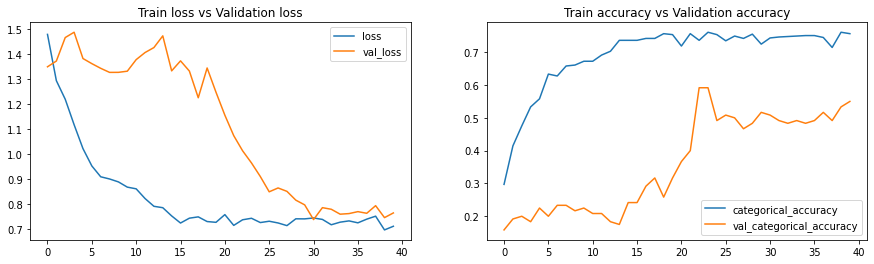

Max. Training Accuracy 0.760869562625885
Max. Validaiton Accuracy 0.5916666388511658


In [26]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(CNN2D_Model_1_History)

In [27]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : CNN2D_Model_1_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Conv3D Layer Kernel Size :',kernelsize)
print(color.TAB+'# MaxPool3D Pool Size : ', poolsize)
print(color.TAB+'# Total Params : 698,789')
print(color.TAB+'# Trainable Params : 698,277')
print(color.TAB+'# Non Trainable Params : 512')
print(color.TAB+"# Max. Training Accuracy :", max(CNN2D_Model_1_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(CNN2D_Model_1_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : CNN2D_Model_1_History
	# No. of Frames :  30
	# Batch Size :  30
	# Image Dimensions : ( 100 , 100 )
	# No. of Epochs :  40
	# Conv3D Layer Kernel Size : (3, 3)
	# MaxPool3D Pool Size :  (2, 2)
	# Total Params : 698,789
	# Trainable Params : 698,277
	# Non Trainable Params : 512
	# Max. Training Accuracy : 0.760869562625885
	# Max. Validaiton Accuracy : 0.5916666388511658


Model Training and Validation Plots for Loss and Training are trending in right direction.

Training Parameters are lower than the ones for the Conv3D Model 2 (so far the best model).

Decision: Increase the number of Epochs and check for better results.

#### Conv 2D + LSTM : Model 2
**With Augment Data and increase epoch**

In [20]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv 3d Kernel Size, Max Pool 3d Pool Size
num_class=5
img_h, img_w=100,100
num_channels, s_frames, batch_size, num_epochs, lstm_n = 3, 30, 30, 50, 32
neurons_density_1, neurons_density_2 = 32, 32
drop_out_1, drop_out_2 = 0.25, 0.25
kernelsize=(3,3)
poolsize=(2,2)

In [21]:
CNN2D_Model_2=Conv2d_RNN_1()
CNN2D_Model_2.project_path()
CNN2D_Model_2.init_properties(img_h,img_w)
CNN2D_Model_2.init_hyparams(s_frames, batch_size, num_epochs)
CNN_2d_LSTM_model_2=CNN2D_Model_2.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2, drop_out_1,drop_out_2,lstm_n)
CNN_2d_LSTM_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 30, 100, 100, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 30, 100, 100, 32)  128      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 50, 50, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 30, 50, 50, 32)   9248      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 50, 50, 32)  

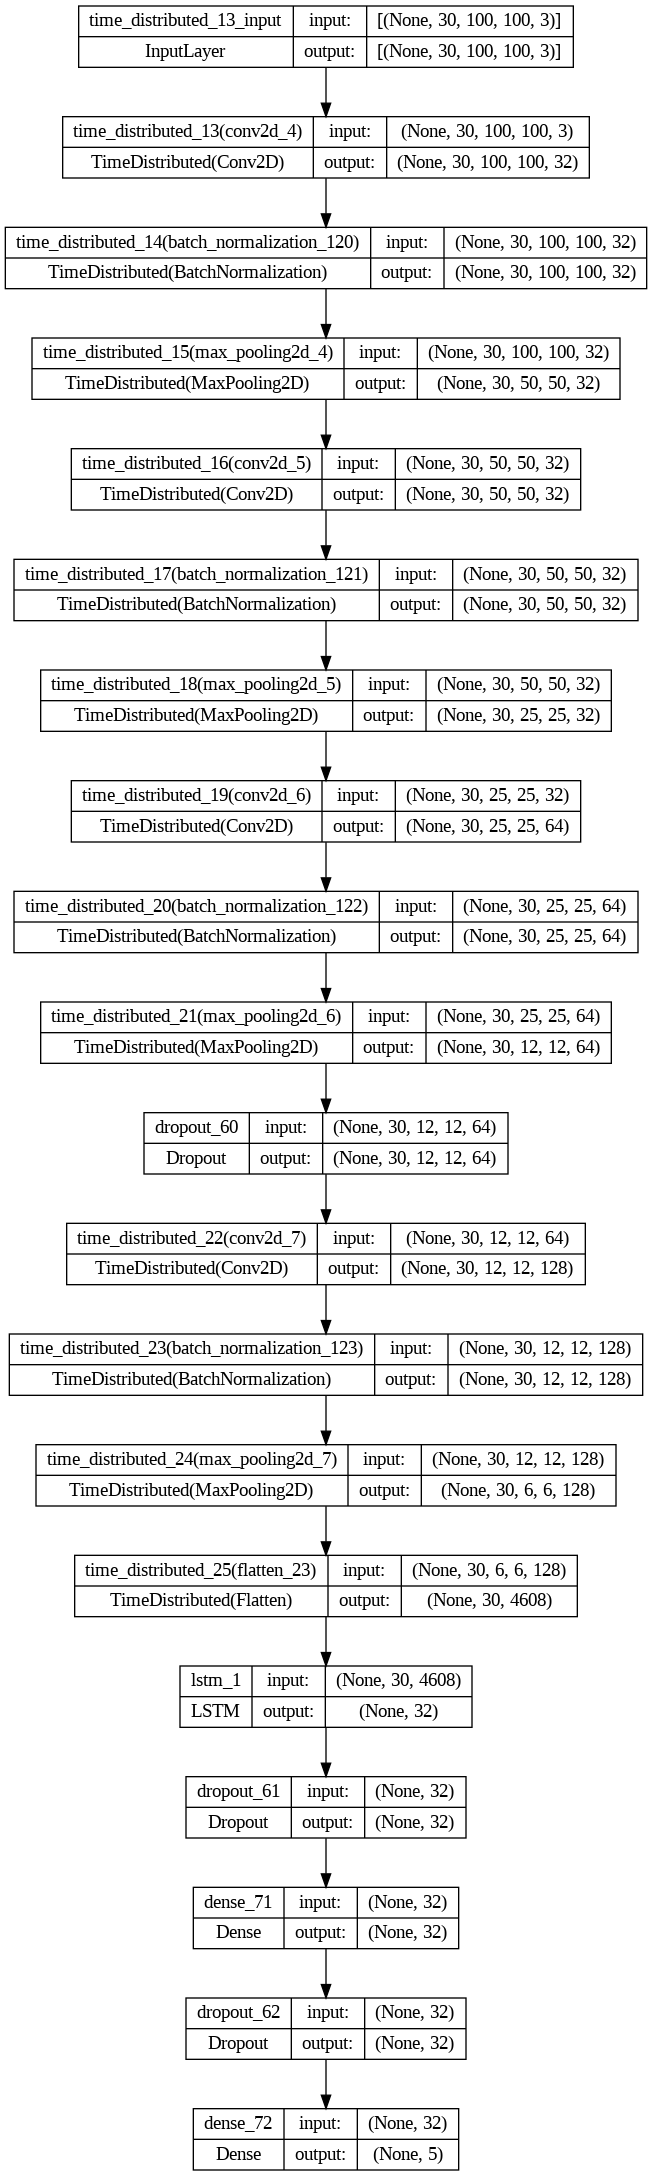

In [85]:
# Visualize the Model Architecture
plot_model(CNN_2d_LSTM_model_2, to_file='CNN_CNN_2d_LSTM_model_22d_LSTM_model_1.png', show_shapes=True, show_layer_names=True)

In [ ]:
# CNN2D Model with Augment Data
CNN2D_Model_2_History=CNN2D_Model_2.create_model_tain(CNN_2d_LSTM_model_2, augment_data=True, monit=False)

Epoch 1/50


2023-08-09 14:44:11.006056: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 1.4813 - categorical_accuracy: 0.2768 
Epoch 00001: saving model to model_init_2023-08-0914_43_56.559360/model-00001-1.48126-0.27681-1.35578-0.17500.h5
23/23 [==============================] - 292s 13s/step - loss: 1.4813 - categorical_accuracy: 0.2768 - val_loss: 1.3558 - val_categorical_accuracy: 0.1750 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 1.3690 - categorical_accuracy: 0.3565 
Epoch 00002: saving model to model_init_2023-08-0914_43_56.559360/model-00002-1.36902-0.35652-1.33625-0.20000.h5
23/23 [==============================] - 279s 13s/step - loss: 1.3690 - categorical_accuracy: 0.3565 - val_loss: 1.3362 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 1.2772 - categorical_accuracy: 0.4370 
Epoch 00003: saving model to model_init_2023-08-0914_43_56.559360/model-00003-1.27722-0.43696-1.35963-0.18333.h5
23/23 [========

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(CNN2D_Model_2_History.history)
hist_csv_file = 'CNN2D_Model_2_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

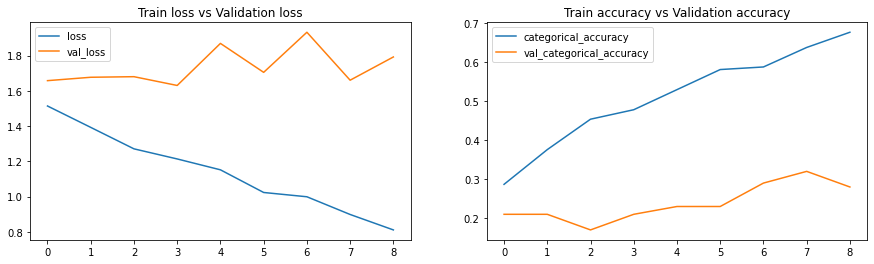

Max. Training Accuracy 0.6764705777168274
Max. Validaiton Accuracy 0.3199999928474426


In [ ]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(CNN2D_Model_2_History)

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : CNN2D_Model_2_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Conv3D Layer Kernel Size :',kernelsize)
print(color.TAB+'# MaxPool3D Pool Size : ', poolsize)
print(color.TAB+'# Total Params : 698,789')
print(color.TAB+'# Trainable Params : 698,277')
print(color.TAB+'# Non Trainable Params : 512')
print(color.TAB+"# Max. Training Accuracy :", max(CNN2D_Model_2_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(CNN2D_Model_2_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : CNN2D_Model_2_History
	# No. of Frames :  30
	# Batch Size :  20
	# Image Dimensions : ( 100 , 100 )
	# No. of Epochs :  40
	# Conv3D Layer Kernel Size : (3, 3)
	# MaxPool3D Pool Size :  (2, 2)
	# Total Params : 698,789
	# Trainable Params : 698,277
	# Non Trainable Params : 512
	# Max. Training Accuracy : 0.6764705777168274
	# Max. Validaiton Accuracy : 0.3199999928474426


#### Conv 2D + GRU

In [86]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv 3d Kernel Size, Max Pool 3d Pool Size
num_class=5
img_h, img_w=100,100
num_channels, s_frames, batch_size, num_epochs, GRU_n = 3, 30, 20, 40, 64
neurons_density_1, neurons_density_2 = 32, 32
drop_out_1, drop_out_2 = 0.25, 0.25
kernelsize=(3,3)
poolsize=(2,2)

In [87]:
class Conv2d_RNN_1(BuildModel):

    def define_model(self,num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2,drop_out_1,drop_out_2, GRU_n):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(32,kernelsize, padding='same', activation='relu'),
                                  input_shape=(s_frames,img_h,img_w,num_channels)))
        model.add(BatchNormalization())
        model.add(TimeDistributed(MaxPooling2D(poolsize)))
        model.add(Dropout(drop_out_1))

        model.add(TimeDistributed(Conv2D(32, kernelsize , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(poolsize)))


        model.add(TimeDistributed(Conv2D(64, kernelsize , padding='same', activation='relu')))
        model.add(BatchNormalization())
        model.add(TimeDistributed(MaxPooling2D(poolsize)))
        model.add(Dropout(drop_out_1))

        model.add(TimeDistributed(Conv2D(128, kernelsize , padding='same', activation='relu')))
        model.add(BatchNormalization())
        model.add(TimeDistributed(MaxPooling2D(poolsize)))
        model.add(Dropout(drop_out_1))


        model.add(TimeDistributed(GlobalAveragePooling2D()))

        model.add(TimeDistributed(Dense(neurons_density_1,activation='relu')))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out_2))

        model.add(GRU(GRU_n))
        model.add(BatchNormalization())

        model.add(Dense(num_class, activation='softmax'))
        optimiser = optimizers.Adam(0.01)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [88]:
CNN2D_Model_3=Conv2d_RNN_1()
CNN2D_Model_3.project_path()
CNN2D_Model_3.init_properties(img_h,img_w)
CNN2D_Model_3.init_hyparams(s_frames, batch_size, num_epochs)
CNN_2d_GRU_model_1=CNN2D_Model_3.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2, drop_out_1,drop_out_2,lstm_n)
CNN_2d_GRU_model_1.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 30, 100, 100, 32)  896      
 stributed)                                                      
                                                                 
 batch_normalization_124 (Ba  (None, 30, 100, 100, 32)  128      
 tchNormalization)                                               
                                                                 
 time_distributed_27 (TimeDi  (None, 30, 50, 50, 32)   0         
 stributed)                                                      
                                                                 
 dropout_63 (Dropout)        (None, 30, 50, 50, 32)    0         
                                                                 
 time_distributed_28 (TimeDi  (None, 30, 50, 50, 32)   9248      
 stributed)                                          

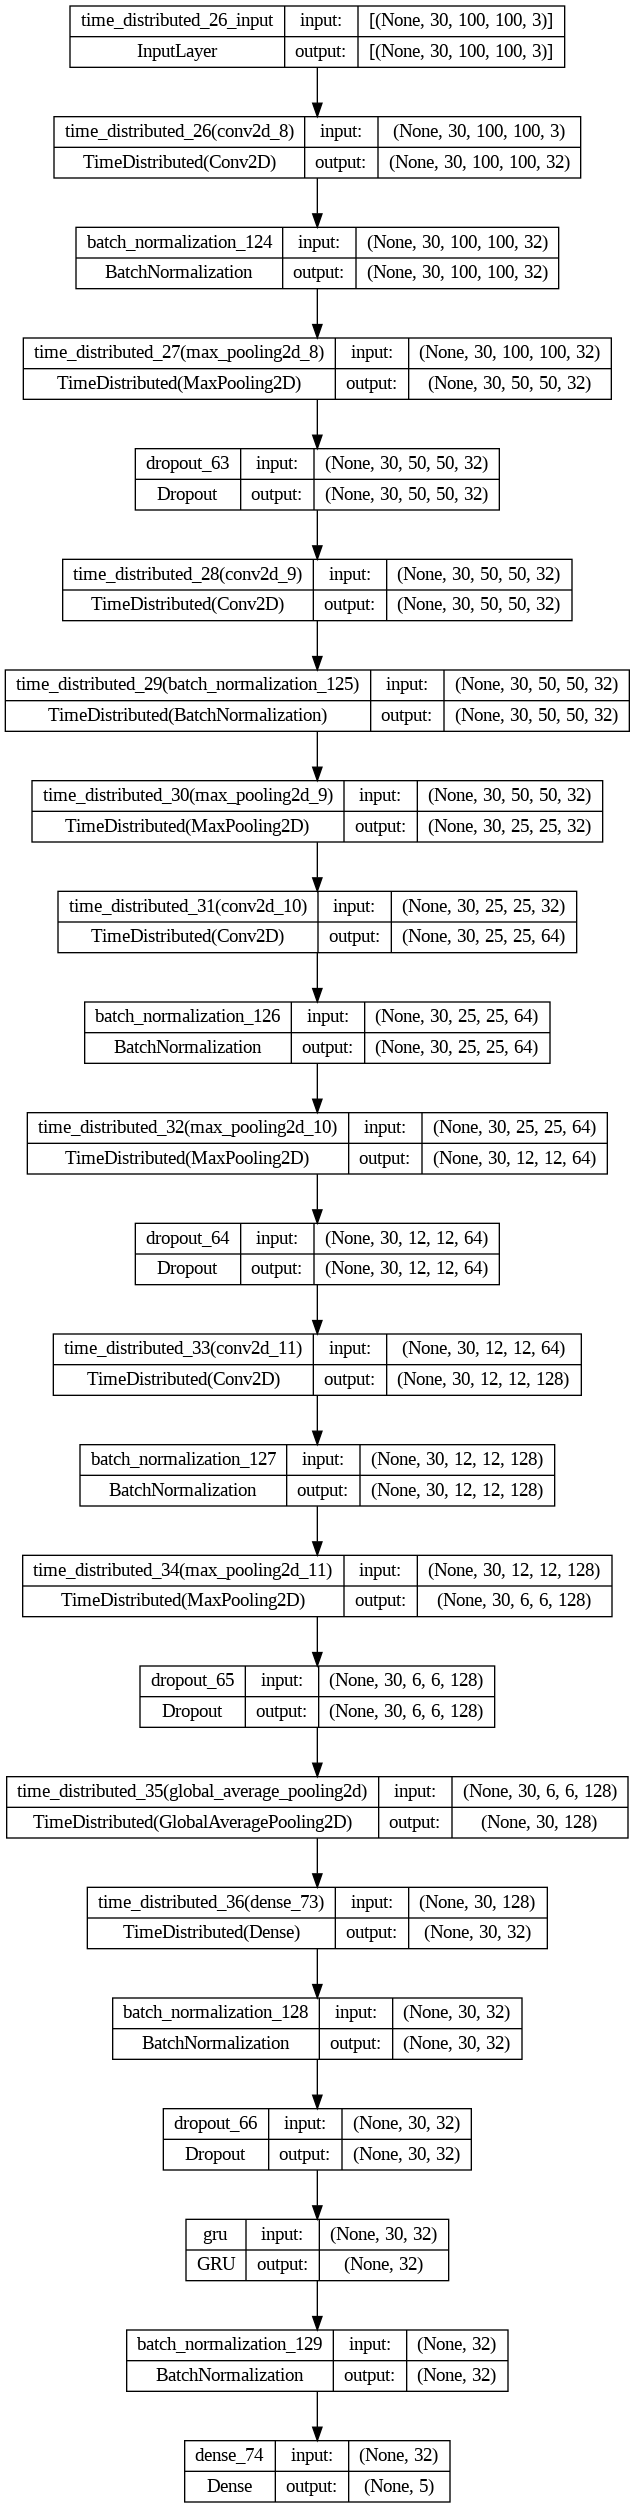

In [89]:
# Visualize the Model Architecture
plot_model(CNN_2d_GRU_model_1, to_file='CNN_2d_GRU_model_1.png', show_shapes=True, show_layer_names=True)

In [ ]:
# CNN2D Model with Augment Data
CNN2D_Model_3_History=CNN2D_Model_3.create_model_tain(CNN_2d_GRU_model_1, augment_data=True)

Epoch 1/40
34/34 [==============================] - ETA: 0s - loss: 1.3710 - categorical_accuracy: 0.3559
Epoch 00001: saving model to model_init_2023-08-0802_04_03.441226/model-00001-1.37095-0.35588-2.09871-0.17000.h5
34/34 [==============================] - 295s 9s/step - loss: 1.3710 - categorical_accuracy: 0.3559 - val_loss: 2.0987 - val_categorical_accuracy: 0.1700 - lr: 0.0100
Epoch 2/40
34/34 [==============================] - ETA: 0s - loss: 1.0811 - categorical_accuracy: 0.4647
Epoch 00002: saving model to model_init_2023-08-0802_04_03.441226/model-00002-1.08110-0.46471-2.82280-0.19000.h5
34/34 [==============================] - 276s 8s/step - loss: 1.0811 - categorical_accuracy: 0.4647 - val_loss: 2.8228 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 3/40
34/34 [==============================] - ETA: 0s - loss: 1.0775 - categorical_accuracy: 0.4654
Epoch 00003: saving model to model_init_2023-08-0802_04_03.441226/model-00003-1.07746-0.46544-2.78454-0.22000.h5
34/34 [==

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(CNN2D_Model_3_History.history)
hist_csv_file = 'CNN2D_Model_3_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

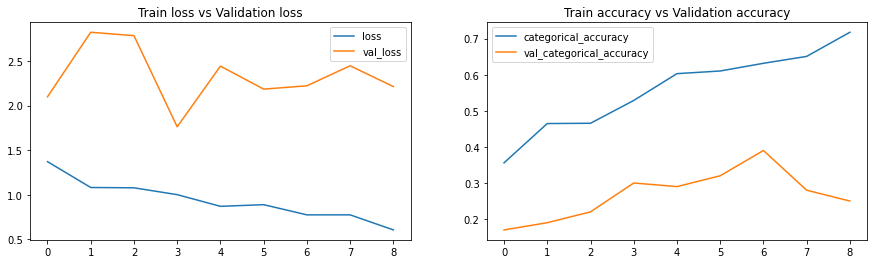

Max. Training Accuracy 0.7176470756530762
Max. Validaiton Accuracy 0.38999998569488525


In [ ]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(CNN2D_Model_3_History)

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : CNN2D_Model_3_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Conv3D Layer Kernel Size :',kernelsize)
print(color.TAB+'# MaxPool3D Pool Size : ', poolsize)
print(color.TAB+'# Total Params : 114,405')
print(color.TAB+'# Trainable Params : 114,405')
print(color.TAB+'# Non Trainable Params : 640')
print(color.TAB+"# Max. Training Accuracy :", max(CNN2D_Model_3_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(CNN2D_Model_3_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : CNN2D_Model_3_History
	# No. of Frames :  30
	# Batch Size :  20
	# Image Dimensions : ( 100 , 100 )
	# No. of Epochs :  40
	# Conv3D Layer Kernel Size : (3, 3)
	# MaxPool3D Pool Size :  (2, 2)
	# Total Params : 114,405
	# Trainable Params : 114,405
	# Non Trainable Params : 640
	# Max. Training Accuracy : 0.7176470756530762
	# Max. Validaiton Accuracy : 0.38999998569488525


#### CNN 2D + Transfer Learning with GRU

In [90]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv 3d Kernel Size, Max Pool 3d Pool Size
num_class=5
img_h, img_w=100,100  # using the default mobilnet image deimensions
num_channels, s_frames, batch_size, num_epochs, GRU_n = 3, 30, 20, 25, 64
neurons_density_1, neurons_density_2 = 64,64
drop_out_1, drop_out_2 = 0.25, 0.25
kernelsize=(3,3)
poolsize=(2,2)
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [91]:
class Conv2d_RNN_2(BuildModel):

    def define_model(self,num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2,drop_out_1,drop_out_2, GRU_n):

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(s_frames,img_h,img_w,num_channels)))


        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(poolsize)))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(GRU_n))
        model.add(Dropout(drop_out_1))

        model.add(Dense(neurons_density_1,activation='relu'))
        model.add(Dropout(drop_out_2))

        model.add(Dense(num_class, activation='softmax'))


        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [92]:
CNN2D_Model_4=Conv2d_RNN_2()
CNN2D_Model_4.project_path()
CNN2D_Model_4.init_properties(img_h,img_w)
CNN2D_Model_4.init_hyparams(s_frames, batch_size, num_epochs)
CNN_2d_mnet_model_4=CNN2D_Model_4.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2, drop_out_1,drop_out_2, GRU_n)
CNN_2d_mnet_model_4.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_37 (TimeDi  (None, 30, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 30, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 30, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 30, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 64)              

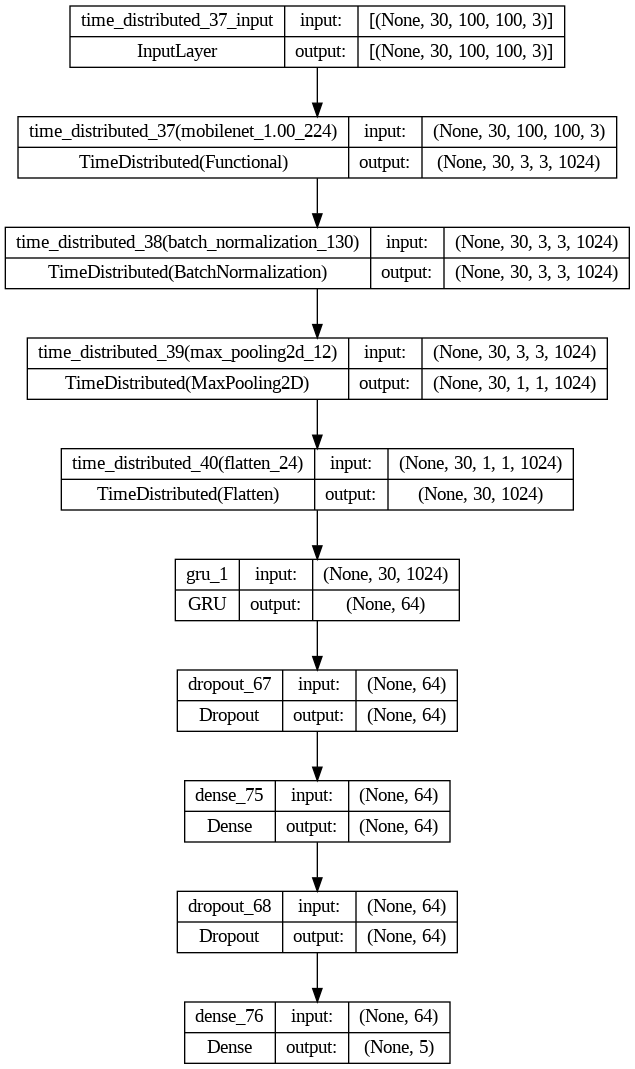

In [93]:
# Visualize the Model Architecture
plot_model(CNN_2d_mnet_model_4, to_file='CNN_2d_mnet_model_4.png', show_shapes=True, show_layer_names=True)

In [ ]:
# CNN2D Model with Augment Data
CNN2D_Model_4_History=CNN2D_Model_4.create_model_tain(CNN_2d_mnet_model_4, augment_data=True)

Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 0.9490 - categorical_accuracy: 0.6074
Epoch 00001: saving model to model_init_2023-08-0802_57_46.451083/model-00001-0.94903-0.60735-0.54650-0.79000.h5
34/34 [==============================] - 281s 8s/step - loss: 0.9490 - categorical_accuracy: 0.6074 - val_loss: 0.5465 - val_categorical_accuracy: 0.7900 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.3524 - categorical_accuracy: 0.8684
Epoch 00002: saving model to model_init_2023-08-0802_57_46.451083/model-00002-0.35242-0.86838-0.35424-0.88000.h5
34/34 [==============================] - 274s 8s/step - loss: 0.3524 - categorical_accuracy: 0.8684 - val_loss: 0.3542 - val_categorical_accuracy: 0.8800 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.2185 - categorical_accuracy: 0.9125
Epoch 00003: saving model to model_init_2023-08-0802_57_46.451083/model-00003-0.21850-0.91250-0.32671-0.88000.h5
34/34 [==

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(CNN2D_Model_4_History.history)
hist_csv_file = 'CNN2D_Model_4_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

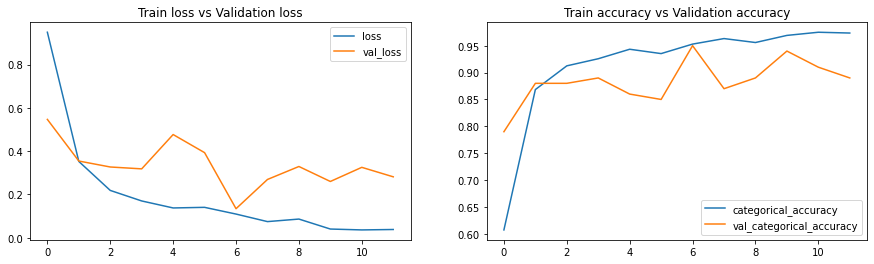

Max. Training Accuracy 0.9750000238418579
Max. Validaiton Accuracy 0.949999988079071


In [ ]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(CNN2D_Model_4_History)

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : CNN2D_Model_4_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Conv3D Layer Kernel Size :',kernelsize)
print(color.TAB+'# MaxPool3D Pool Size : ', poolsize)
print(color.TAB+'# Total Params : 3,446,725')
print(color.TAB+'# Trainable Params : 3,422,789')
print(color.TAB+'# Non Trainable Params : 23,936')
print(color.TAB+"# Max. Training Accuracy :", max(CNN2D_Model_4_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(CNN2D_Model_4_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : CNN2D_Model_4_History
	# No. of Frames :  30
	# Batch Size :  20
	# Image Dimensions : ( 100 , 100 )
	# No. of Epochs :  25
	# Conv3D Layer Kernel Size : (3, 3)
	# MaxPool3D Pool Size :  (2, 2)
	# Total Params : 3,446,725
	# Trainable Params : 3,422,789
	# Non Trainable Params : 23,936
	# Max. Training Accuracy : 0.9750000238418579
	# Max. Validaiton Accuracy : 0.949999988079071


Transfer Learning using “MobileNet”

Callback – Early Stopping at Epoch 12

Better Training and Validation Loss and Accuracy
Loss Training and Validation Loss trend indicate some overfitting. 

** model-00010-0.04013-0.96912-0.25982-0.94000.h5** 
- With Training Loss-0. 0401, Validation Loss - 0.2598 and Training Accuracy - 0.9691, Validation Accuracy - 0.9400, are the best rates for the model.

These results are better than the Conv3D Model 2, but the Training Parameter Count is high, which is expected as we are using Transfer Learning. 
Decision : To check whether if we can Further Improve Loss and Accuracies with lower Training Parameters


#### CNN2D + CnvLSTM2D + GolbalAveragePool

In [94]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv Kernel Size, Max Pool  Pool Size
num_class=5
img_h, img_w=100,100
num_channels, s_frames, batch_size, num_epochs, lstm_n = 3, 30, 16, 50, 8
neurons_density_1, neurons_density_2 = 64,64
drop_out_1, drop_out_2 = 0.25, 0.25
kernelsize=(3,3)
poolsize=(2,2)

In [95]:
class Conv2d_RNN_2(BuildModel):

    def define_model(self,num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2,drop_out_1,drop_out_2, lstm_n):
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, kernelsize, activation='relu'), input_shape=(s_frames,img_h,img_w,num_channels)))
        model.add(BatchNormalization())
        model.add(TimeDistributed(Conv2D(32, kernelsize, activation='relu')))
        model.add(BatchNormalization())
        model.add(ConvLSTM2D(lstm_n, kernel_size = 3, return_sequences=False))
        model.add(BatchNormalization())
        model.add(TimeDistributed(Dense(neurons_density_1, activation='relu')))
        model.add(BatchNormalization())
        model.add(GlobalAveragePooling2D())
        model.add(Dense(neurons_density_2, activation='relu'))
        model.add(Dense(5, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [97]:
CNN2D_Model_5=Conv2d_RNN_2()
CNN2D_Model_5.project_path()
CNN2D_Model_5.init_properties(img_h,img_w)
CNN2D_Model_5.init_hyparams(s_frames, batch_size, num_epochs)
CNN_2d_CLSTM_model_5=CNN2D_Model_5.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2, drop_out_1,drop_out_2, lstm_n)
CNN_2d_CLSTM_model_5.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_41 (TimeDi  (None, 30, 98, 98, 16)   448       
 stributed)                                                      
                                                                 
 batch_normalization_131 (Ba  (None, 30, 98, 98, 16)   64        
 tchNormalization)                                               
                                                                 
 time_distributed_42 (TimeDi  (None, 30, 96, 96, 32)   4640      
 stributed)                                                      
                                                                 
 batch_normalization_132 (Ba  (None, 30, 96, 96, 32)   128       
 tchNormalization)                                               
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 94, 94, 8)       

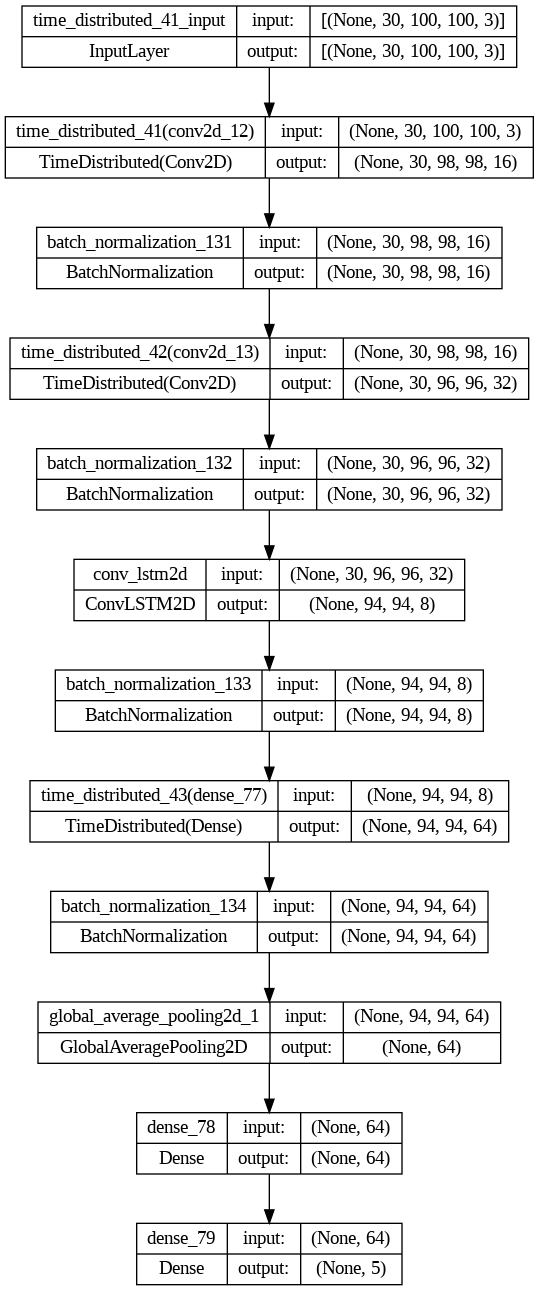

In [98]:
# Visualize the Model Architecture
plot_model(CNN_2d_CLSTM_model_5, to_file='CNN_2d_CLSTM_model_5.png', show_shapes=True, show_layer_names=True)

In [ ]:
# CNN2D Model with Augment Data
CNN2D_Model_5_History=CNN2D_Model_5.create_model_tain(CNN_2d_CLSTM_model_5, augment_data=True, monit=False)

Epoch 1/50
42/42 [==============================] - ETA: 0s - loss: 1.4202 - categorical_accuracy: 0.3884
Epoch 00001: saving model to model_init_2023-08-0809_10_35.415678/model-00001-1.42017-0.38839-1.42876-0.17857.h5
42/42 [==============================] - 348s 8s/step - loss: 1.4202 - categorical_accuracy: 0.3884 - val_loss: 1.4288 - val_categorical_accuracy: 0.1786 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - ETA: 0s - loss: 1.1302 - categorical_accuracy: 0.5439
Epoch 00002: saving model to model_init_2023-08-0809_10_35.415678/model-00002-1.13025-0.54390-1.39989-0.16964.h5
42/42 [==============================] - 319s 8s/step - loss: 1.1302 - categorical_accuracy: 0.5439 - val_loss: 1.3999 - val_categorical_accuracy: 0.1696 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 1.0199 - categorical_accuracy: 0.5759
Epoch 00003: saving model to model_init_2023-08-0809_10_35.415678/model-00003-1.01995-0.57589-1.50520-0.19643.h5
42/42 [==

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(CNN2D_Model_5_History.history)
hist_csv_file = 'CNN2D_Model_5_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

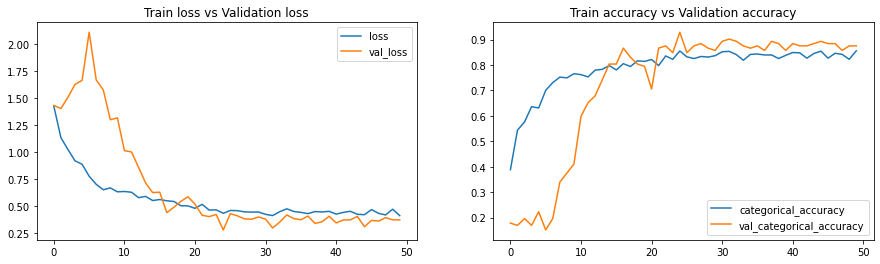

Max. Training Accuracy 0.855654776096344
Max. Validaiton Accuracy 0.9285714030265808


In [ ]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(CNN2D_Model_5_History)

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : CNN2D_Model_5_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Total Params : 22,181')
print(color.TAB+'# Trainable Params : 21,941')
print(color.TAB+'# Non Trainable Params : 240')
print(color.TAB+"# Max. Training Accuracy :", max(CNN2D_Model_5_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(CNN2D_Model_5_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : CNN2D_Model_5_History
	# No. of Frames :  30
	# Batch Size :  16
	# Image Dimensions : ( 100 , 100 )
	# No. of Epochs :  50
	# Total Params : 22,181
	# Trainable Params : 21,941
	# Non Trainable Params : 240
	# Max. Training Accuracy : 0.855654776096344
	# Max. Validaiton Accuracy : 0.9285714030265808


###### Validation Accuracy Trends Higher than Training Accuracy, also the Validation Loss trends lower than Training Loss.
- Is it due Data Augmentation, though this helps with Overfitting problem, but is it impacting the model such that Training Accuracy is lower than Validation Accuracy and vice-a-versa in case of Loss.
**Lets find out by switching of the Data Augmentation for the above model and run the model.**

https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss

#### CNN2D ConvLSTM Global Average Pool : Model 6
**Parameters same as Model 5, but without Data Augmentation.**

In [99]:
# Parameters Initialisation for the Model
# Image Dimensions, Frames, Batch Size, Epochs, Dense Neurons, Drop Out Rate, Learning Rate, Bias (if required)
# Conv Kernel Size, Max Pool  Pool Size
num_class=5
img_h, img_w=100,100
num_channels, s_frames, batch_size, num_epochs, lstm_n = 3, 30, 16, 50, 8
neurons_density_1, neurons_density_2 = 32,64
drop_out_1, drop_out_2 = 0.25, 0.25
kernelsize=(3,3)
poolsize=(2,2)

In [100]:
class Conv2d_RNN_2(BuildModel):

    def define_model(self,num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2,drop_out_1,drop_out_2, lstm_n):
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, kernelsize, activation='relu'), input_shape=(s_frames,img_h,img_w,num_channels)))
        model.add(BatchNormalization())
        model.add(TimeDistributed(Conv2D(16, kernelsize, activation='relu')))
        model.add(BatchNormalization())
        model.add(ConvLSTM2D(lstm_n, kernel_size = 3, return_sequences=False))
        model.add(BatchNormalization())
        model.add(TimeDistributed(Dense(neurons_density_1, activation='relu')))
        model.add(BatchNormalization())
        model.add(GlobalAveragePooling2D())
        model.add(Dense(neurons_density_2, activation='relu'))
        model.add(Dense(5, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [101]:
CNN2D_Model_6=Conv2d_RNN_2()
CNN2D_Model_6.project_path()
CNN2D_Model_6.init_properties(img_h,img_w)
CNN2D_Model_6.init_hyparams(s_frames, batch_size, num_epochs)
CNN_2d_CLSTM_model_6=CNN2D_Model_6.define_model(num_channels, kernelsize,poolsize,neurons_density_1,neurons_density_2, drop_out_1,drop_out_2, lstm_n)
CNN_2d_CLSTM_model_6.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_44 (TimeDi  (None, 30, 98, 98, 16)   448       
 stributed)                                                      
                                                                 
 batch_normalization_135 (Ba  (None, 30, 98, 98, 16)   64        
 tchNormalization)                                               
                                                                 
 time_distributed_45 (TimeDi  (None, 30, 96, 96, 16)   2320      
 stributed)                                                      
                                                                 
 batch_normalization_136 (Ba  (None, 30, 96, 96, 16)   64        
 tchNormalization)                                               
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 94, 94, 8)       

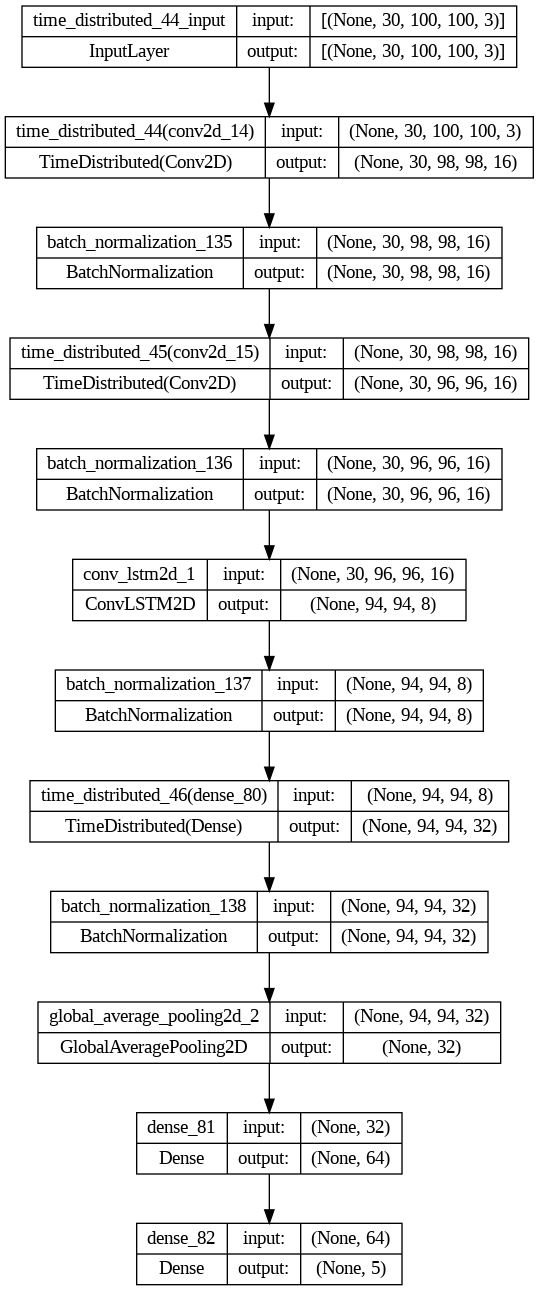

In [102]:
# Visualize the Model Architecture
plot_model(CNN_2d_CLSTM_model_6, to_file='CNN_2d_CLSTM_model_6.png', show_shapes=True, show_layer_names=True)

In [ ]:
# CNN2D Model without Augment Data
CNN2D_Model_6_History=CNN2D_Model_6.create_model_tain(CNN_2d_CLSTM_model_6, augment_data=False, monit=False)

Epoch 1/50
42/42 [==============================] - ETA: 0s - loss: 1.4776 - categorical_accuracy: 0.3661
Epoch 00001: saving model to model_init_2023-08-0816_08_22.631662/model-00001-1.47756-0.36607-1.42082-0.16071.h5
42/42 [==============================] - 169s 4s/step - loss: 1.4776 - categorical_accuracy: 0.3661 - val_loss: 1.4208 - val_categorical_accuracy: 0.1607 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - ETA: 0s - loss: 1.2688 - categorical_accuracy: 0.4524
Epoch 00002: saving model to model_init_2023-08-0816_08_22.631662/model-00002-1.26876-0.45238-1.43483-0.26786.h5
42/42 [==============================] - 163s 4s/step - loss: 1.2688 - categorical_accuracy: 0.4524 - val_loss: 1.4348 - val_categorical_accuracy: 0.2679 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 1.0992 - categorical_accuracy: 0.5402
Epoch 00003: saving model to model_init_2023-08-0816_08_22.631662/model-00003-1.09917-0.54018-1.49786-0.29464.h5
42/42 [==

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(CNN2D_Model_6_History.history)
hist_csv_file = 'CNN2D_Model_6_History.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

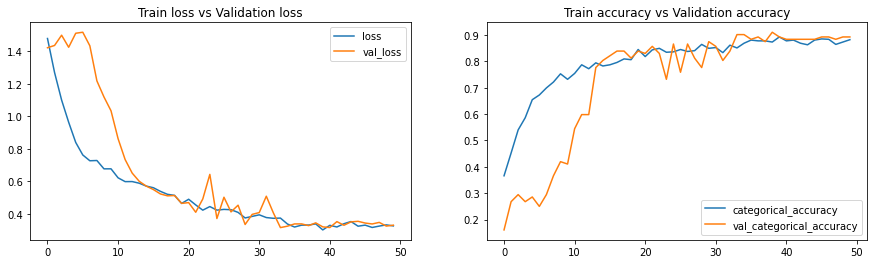

Max. Training Accuracy 0.8928571343421936
Max. Validaiton Accuracy 0.9107142686843872


In [ ]:
# Lets Plot the Loss and Accuracy for Train and Validation.
plot(CNN2D_Model_6_History)

In [ ]:
# Capture the Model Details
print(color.BOLD+'************Model Summary***********'+color.END)
print(color.BOLD+'# Model Name : CNN2D_Model_6_History'+color.END)
print(color.TAB+'# No. of Frames : ', s_frames)
print(color.TAB+'# Batch Size : ', batch_size)
print(color.TAB+'# Image Dimensions : (',img_h,',',img_w,')')
print(color.TAB+'# No. of Epochs : ', num_epochs)
print(color.TAB+'# Total Params : 12,725')
print(color.TAB+'# Trainable Params : 12,581')
print(color.TAB+'# Non Trainable Params : 144')
print(color.TAB+"# Max. Training Accuracy :", max(CNN2D_Model_6_History.history['categorical_accuracy']))
print(color.TAB+"# Max. Validaiton Accuracy :", max(CNN2D_Model_6_History.history['val_categorical_accuracy']))

************Model Summary***********
# Model Name : CNN2D_Model_6_History
	# No. of Frames :  30
	# Batch Size :  16
	# Image Dimensions : ( 100 , 100 )
	# No. of Epochs :  50
	# Total Params : 22,181
	# Trainable Params : 21,941
	# Non Trainable Params : 240
	# Max. Training Accuracy : 0.8928571343421936
	# Max. Validaiton Accuracy : 0.9107142686843872
